In [2]:
!pip install chardet==5.2.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.4/199.4 kB 19.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


# Checkpoint

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import zipfile
import matplotlib.gridspec as gridspec
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import chardet
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import pickle as pkl

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')



with open('/work/checkpoint2.pkl', 'rb') as f:
    checkpoint2 = pkl.load(f)

# Accessing variables
X_train = checkpoint2['X_train']
y_train = checkpoint2['y_train']
X_val = checkpoint2['X_val']
X_test = checkpoint2['X_test']
y_val = checkpoint2['y_val']
y_test = checkpoint2['y_test']
data_cleaned = checkpoint2['data_cleaned']

print("Checkpoint loaded successfully")


total = X_train.shape[0] + X_val.shape[0] + X_test.shape[0]
# Verify the splits
print(f"Training percentage: {(X_train.shape[0])/total*100}")
print(f"Validation percentage: {(X_val.shape[0])/total*100}")
print(f"Test percentage: {(X_test.shape[0])/total*100}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Checkpoint loaded successfully
Training percentage: 69.99827794041674
Validation percentage: 14.99913897020837
Test percentage: 15.002583089374893


# Initial model

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer  # change
from sklearn.metrics import cohen_kappa_score, classification_report, f1_score, roc_auc_score  # change
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import random
import tensorflow as tf

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Convert label_list to proper multi-label format
mlb = MultiLabelBinarizer()  # change
y = data_cleaned['label_list']
one_hot_labels = mlb.fit_transform(y)  # change
num_classes = one_hot_labels.shape[1]  # change

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(data_cleaned['resume'])
sequences = tokenizer.texts_to_sequences(data_cleaned['resume'])
max_sequence_length = 100
X_features = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# Initialize MultilabelStratifiedShuffleSplit for Train and Temp (40%)
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
train_idx, temp_idx = next(msss.split(X_features, one_hot_labels))

X_train, y_train = X_features[train_idx], one_hot_labels[train_idx]
X_temp, y_temp = X_features[temp_idx], one_hot_labels[temp_idx]

# Initialize MultilabelStratifiedShuffleSplit for Validation and Test (each 50% of Temp, i.e., 20% each of total)
msss_val_test = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx_rel, test_idx_rel = next(msss_val_test.split(X_temp, y_temp))

# Map relative indices back to absolute indices
val_idx = temp_idx[val_idx_rel]
test_idx = temp_idx[test_idx_rel]

X_val, y_val = X_features[val_idx], one_hot_labels[val_idx]
X_test, y_test = X_features[test_idx], one_hot_labels[test_idx]

model = Sequential([
    Embedding(input_dim=10000, output_dim=100, input_shape=(max_sequence_length,)),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=5),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='sigmoid')  # change: 'sigmoid' for multi-label classification
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',  # change: use 'binary_crossentropy' for multi-label classification
    metrics=[]  # No changes needed here
)

model.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_model_tuned.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

best_model = model
best_model.load_weights('best_model_tuned.keras')

print("\nEvaluating on the Validation Set:")

y_pred_val_probs = best_model.predict(X_val)  # change
y_pred_val = (y_pred_val_probs >= 0.5).astype(int)  # change: convert probabilities to binary values (threshold=0.5)

kappa_val = cohen_kappa_score(y_val.flatten(), y_pred_val.flatten())  # change: flatten arrays for multi-label kappa
print(f"Cohen's Kappa (Validation Set): {kappa_val:.4f}")

print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_pred_val, target_names=mlb.classes_, zero_division=0))  # change

# Calculate F1-Score
weighted_f1 = f1_score(y_val, y_pred_val, average='weighted')
print(f"F1-Score (Validation Set): {weighted_f1:.4f}")

# Calculate ROC AUC Score
try:
    auc_val = roc_auc_score(y_val, y_pred_val_probs, average='macro')  # change: compute AUC
    print(f"ROC AUC Score (Validation Set): {auc_val:.4f}")
except ValueError as e:
    print(f"ROC AUC Score (Validation Set) could not be computed: {e}")


2024-10-20 17:26:50.123315: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-20 17:26:50.398267: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-10-20 17:26:50.398292: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-10-20 17:26:50.420674: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-20 17:26:51.834268: W tensorflow/stream_executor/platform/de

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer  # change
from sklearn.metrics import cohen_kappa_score, classification_report, f1_score, roc_auc_score  # change
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import random
import tensorflow as tf

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Convert label_list to proper multi-label format
mlb = MultiLabelBinarizer()  # change
y = data_cleaned['label_list']
one_hot_labels = mlb.fit_transform(y)  # change
num_classes = one_hot_labels.shape[1]  # change

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(data_cleaned['resume'])
sequences = tokenizer.texts_to_sequences(data_cleaned['resume'])
max_sequence_length = 1000
X_features = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# Initialize MultilabelStratifiedShuffleSplit for Train and Temp (40%)
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
train_idx, temp_idx = next(msss.split(X_features, one_hot_labels))

X_train, y_train = X_features[train_idx], one_hot_labels[train_idx]
X_temp, y_temp = X_features[temp_idx], one_hot_labels[temp_idx]

# Initialize MultilabelStratifiedShuffleSplit for Validation and Test (each 50% of Temp, i.e., 20% each of total)
msss_val_test = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx_rel, test_idx_rel = next(msss_val_test.split(X_temp, y_temp))

# Map relative indices back to absolute indices
val_idx = temp_idx[val_idx_rel]
test_idx = temp_idx[test_idx_rel]

X_val, y_val = X_features[val_idx], one_hot_labels[val_idx]
X_test, y_test = X_features[test_idx], one_hot_labels[test_idx]

model = Sequential([
    Embedding(input_dim=10000, output_dim=100, input_shape=(max_sequence_length,)),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=5),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='sigmoid')  # change: 'sigmoid' for multi-label classification
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',  # change: use 'binary_crossentropy' for multi-label classification
    metrics=[]  # No changes needed here
)

model.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_model_tuned.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

best_model = model
best_model.load_weights('best_model_tuned.keras')

print("\nEvaluating on the Validation Set:")

y_pred_val_probs = best_model.predict(X_val)  # change
y_pred_val = (y_pred_val_probs >= 0.5).astype(int)  # change: convert probabilities to binary values (threshold=0.5)

kappa_val = cohen_kappa_score(y_val.flatten(), y_pred_val.flatten())  # change: flatten arrays for multi-label kappa
print(f"Cohen's Kappa (Validation Set): {kappa_val:.4f}")

print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_pred_val, target_names=mlb.classes_, zero_division=0))  # change

# Calculate F1-Score
weighted_f1 = f1_score(y_val, y_pred_val, average='weighted')
print(f"F1-Score (Validation Set): {weighted_f1:.4f}")

# Calculate ROC AUC Score
try:
    auc_val = roc_auc_score(y_val, y_pred_val_probs, average='macro')  # change: compute AUC
    print(f"ROC AUC Score (Validation Set): {auc_val:.4f}")
except ValueError as e:
    print(f"ROC AUC Score (Validation Set) could not be computed: {e}")


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 100)         1000000   
                                                                 
 conv1d_1 (Conv1D)           (None, 996, 128)          64128     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 199, 128)         0         
 1D)                                                             
                                                                 
 global_average_pooling1d_1   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)              

# Hyperparameter tuning

In [7]:
import keras_tuner as kt
def build_model(hp):
    model = Sequential()
    # Embedding layer remains unchanged
    model.add(Embedding(input_dim=10000, output_dim=100, input_shape=(max_sequence_length,)))
    
    # Tune the number of filters in Conv1D
    hp_filters = hp.Int('filters', min_value=64, max_value=256, step=64, default=128)
    # Tune the kernel size in Conv1D
    hp_kernel_size = hp.Choice('kernel_size', values=[3, 5, 7], default=5)
    model.add(Conv1D(filters=hp_filters, kernel_size=hp_kernel_size, activation='relu'))
    
    # MaxPooling remains unchanged
    model.add(MaxPooling1D(pool_size=5))
    model.add(GlobalAveragePooling1D())
    
    # Dense layer units
    hp_dense_units = hp.Int('dense_units', min_value=64, max_value=256, step=64, default=128)
    model.add(Dense(units=hp_dense_units, activation='relu'))
    
    # Tune the dropout rate
    hp_dropout = hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1, default=0.5)
    model.add(Dropout(rate=hp_dropout))
    
    # Output layer remains unchanged
    model.add(Dense(num_classes, activation='sigmoid'))
    
    # Tune the learning rate for Adam optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4], default=1e-3)
    
    model.compile(
        optimizer=Adam(learning_rate=hp_learning_rate),
        loss='binary_crossentropy',
        metrics=[]  # You can add metrics like 'accuracy' if desired
    )
    
    return model
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of models built and fit for each trial
    directory='keras_tuner_dir',
    project_name='cnn_hyperparameter_tuning'
)
tuner.search_space_summary()
tuner.search(
    X_train, y_train,
    epochs=3,  # Reduced epochs for tuning
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint],
    batch_size=32,  # Starting with default batch size
    verbose=1
)
# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\nBest Hyperparameters Found:")
print(f"Learning Rate: {best_hps.get('learning_rate')}")
print(f"Filters: {best_hps.get('filters')}")
print(f"Kernel Size: {best_hps.get('kernel_size')}")
print(f"Dense Units: {best_hps.get('dense_units')}")
print(f"Dropout Rate: {best_hps.get('dropout_rate')}")


Trial 10 Complete [00h 01m 29s]
val_loss: 0.17781320214271545

Best val_loss So Far: 0.16918058693408966
Total elapsed time: 00h 22m 09s

Best Hyperparameters Found:
Learning Rate: 0.001
Filters: 128
Kernel Size: 7
Dense Units: 128
Dropout Rate: 0.3



Classes: ['Database_Administrator' 'Front_End_Developer' 'Java_Developer'
 'Network_Administrator' 'Project_manager' 'Python_Developer'
 'Security_Analyst' 'Software_Developer' 'Systems_Administrator'
 'Web_Developer']
One-Hot Encoded Labels Shape: (29035, 10)

Tokenized and Padded Sequences Shape: (29035, 100)

Training Samples: 17389
Validation Samples: 5792
Test Samples: 5854
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 conv1d_1 (Conv1D)           (None, 94, 128)           89728     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 18, 128)          0         
 1D)                                                             
                                                                 
 

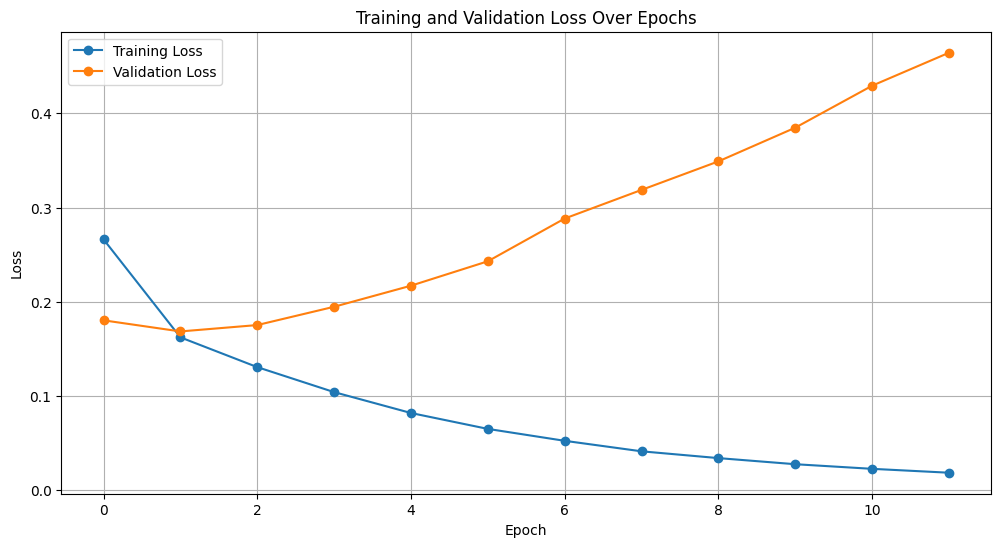


Final model saved as 'final_cnn_model.h5'


In [9]:
# ========================================
# Import Necessary Libraries
# ========================================
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import (
    cohen_kappa_score,
    classification_report,
    f1_score,
    roc_auc_score
)
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Embedding,
    Conv1D,
    MaxPooling1D,
    GlobalAveragePooling1D,
    Dense,
    Dropout
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt

# ========================================
# 1. Set Seeds for Reproducibility
# ========================================
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    # For TensorFlow 2.x, setting the following is also recommended
    tf.keras.utils.set_random_seed(seed)

set_seeds(42)

# ========================================
# 2. Data Preprocessing
# ========================================
# Assuming 'data_cleaned' is your DataFrame with 'resume' and 'label_list' columns
# Example:
# data_cleaned = pd.read_csv('your_data.csv')

# Convert label_list to proper multi-label format
mlb = MultiLabelBinarizer()
y = data_cleaned['label_list']
one_hot_labels = mlb.fit_transform(y)
num_classes = one_hot_labels.shape[1]

print("\nClasses:", mlb.classes_)
print("One-Hot Encoded Labels Shape:", one_hot_labels.shape)

# Tokenize the resumes
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(data_cleaned['resume'])
sequences = tokenizer.texts_to_sequences(data_cleaned['resume'])
max_sequence_length = 100
X_features = pad_sequences(
    sequences, maxlen=max_sequence_length, padding='post', truncating='post'
)

print("\nTokenized and Padded Sequences Shape:", X_features.shape)

# ========================================
# 3. Stratified Data Splitting
# ========================================
# Initialize MultilabelStratifiedShuffleSplit for Train and Temp (40%)
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
train_idx, temp_idx = next(msss.split(X_features, one_hot_labels))

X_train, y_train = X_features[train_idx], one_hot_labels[train_idx]
X_temp, y_temp = X_features[temp_idx], one_hot_labels[temp_idx]

# Initialize MultilabelStratifiedShuffleSplit for Validation and Test (each 50% of Temp, i.e., 20% each of total)
msss_val_test = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx_rel, test_idx_rel = next(msss_val_test.split(X_temp, y_temp))

# Map relative indices back to absolute indices
val_idx = temp_idx[val_idx_rel]
test_idx = temp_idx[test_idx_rel]

X_val, y_val = X_features[val_idx], one_hot_labels[val_idx]
X_test, y_test = X_features[test_idx], one_hot_labels[test_idx]

print("\nTraining Samples:", X_train.shape[0])
print("Validation Samples:", X_val.shape[0])
print("Test Samples:", X_test.shape[0])

# ========================================
# 4. Define the CNN Model with Best Hyperparameters
# ========================================
# Best Hyperparameters Found:
# - Learning Rate: 0.001
# - Filters: 128
# - Kernel Size: 7
# - Dense Units: 128
# - Dropout Rate: 0.3

# Define the updated model
model = Sequential([
    Embedding(input_dim=10000, output_dim=100, input_length=max_sequence_length),
    Conv1D(filters=128, kernel_size=7, activation='relu'),
    MaxPooling1D(pool_size=5),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='sigmoid')  # For multi-label classification
])

# Compile the model with the optimized learning rate
optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',  # Suitable for multi-label classification
    metrics=[]  # You can add metrics like 'accuracy' if desired
)

# Display the model summary
model.summary()

# ========================================
# 5. Set Up Callbacks
# ========================================
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Increased patience for final training
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_cnn_model.h5',  # Updated filename for clarity
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# ========================================
# 6. Train the Model
# ========================================
# Define training parameters
batch_size = 32
epochs = 50  # Increased from 10 to allow the model to fully train

# Train the model
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# ========================================
# 7. Load the Best Model
# ========================================
# Load the best model saved during training
best_model = load_model('best_cnn_model.h5')
print("\nLoaded Best Model Summary:")
best_model.summary()

# ========================================
# 8. Evaluate the Model
# ========================================
def evaluate_model(model, X, y, mlb, dataset_name="Validation"):
    # Predict probabilities
    y_pred_probs = model.predict(X)
    
    # Convert probabilities to binary predictions (threshold=0.5)
    y_pred = (y_pred_probs >= 0.5).astype(int)
    
    # Calculate Cohen's Kappa Score
    kappa = cohen_kappa_score(y.flatten(), y_pred.flatten())
    print(f"\nCohen's Kappa Score ({dataset_name} Set): {kappa:.4f}")
    
    # Classification Report
    print(f"\nClassification Report ({dataset_name} Set):")
    print(classification_report(y, y_pred, target_names=mlb.classes_, zero_division=0))
    
    # Calculate Weighted F1-Score
    weighted_f1 = f1_score(y, y_pred, average='weighted')
    print(f"Weighted F1-Score ({dataset_name} Set): {weighted_f1:.4f}")
    
    # Calculate ROC AUC Score
    try:
        auc = roc_auc_score(y, y_pred_probs, average='macro')
        print(f"ROC AUC Score ({dataset_name} Set): {auc:.4f}")
    except ValueError as e:
        print(f"ROC AUC Score ({dataset_name} Set) could not be computed: {e}")

# Evaluate on Validation Set
print("\nEvaluating on the Validation Set:")
evaluate_model(best_model, X_val, y_val, mlb, dataset_name="Validation")

# Evaluate on Test Set
print("\nEvaluating on the Test Set:")
evaluate_model(best_model, X_test, y_test, mlb, dataset_name="Test")

# ========================================
# 9. Visualize Training History (Optional)
# ========================================
# Plot Training & Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# ========================================
# 10. Save the Final Model (Optional)
# ========================================
# If satisfied with the performance, save the final model
best_model.save('final_cnn_model.h5')
print("\nFinal model saved as 'final_cnn_model.h5'")


Cleaned DataFrame:
   Tuning         Metric   Score
0  Before  Cohen's Kappa  0.7718
1   After  Cohen's Kappa  0.7749
2  Before    Weighted F1  0.8043
3   After    Weighted F1  0.8090
4  Before        ROC AUC  0.9529
5   After        ROC AUC  0.9535


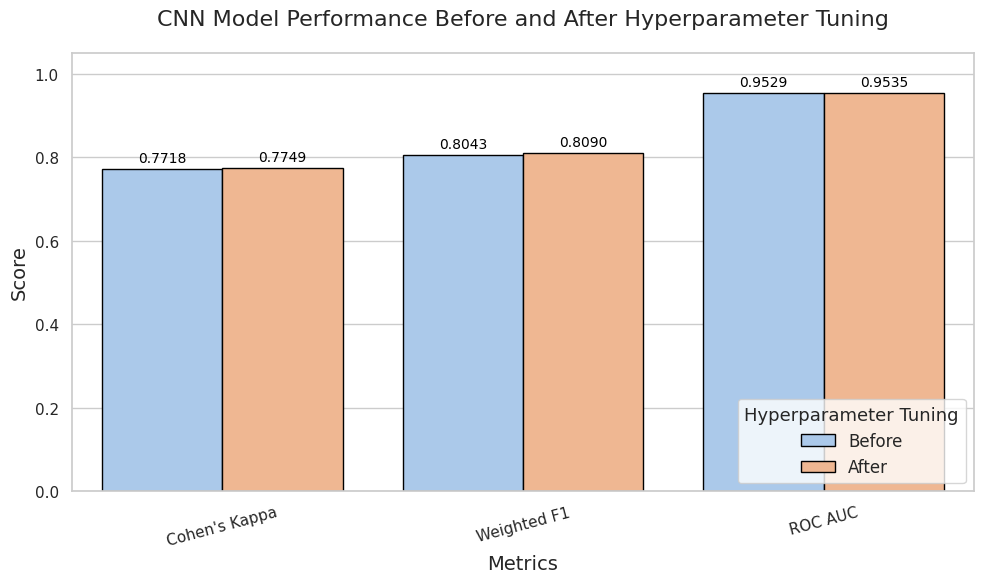

In [3]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Define your cleaned data for GCN only
data_cnn_clean = {
    'Tuning': ['Before', 'After', 'Before', 'After', 'Before', 'After'],
    'Metric': ["Cohen's Kappa", "Cohen's Kappa", 'Weighted F1', 'Weighted F1', 'ROC AUC', 'ROC AUC'],
    'Score': [0.7718, 0.7749, 0.8043, 0.8090, 0.9529, 0.9535]
}

# Create the cleaned DataFrame
df_clean = pd.DataFrame(data_cnn_clean)

# Display the cleaned DataFrame for verification
print("Cleaned DataFrame:")
print(df_clean)

# Verify that all 'Score' values are numeric and greater than zero
if df_clean['Score'].isnull().any():
    raise ValueError("There are NaN values in the 'Score' column. Please check your data.")
if (df_clean['Score'] <= 0).any():
    print("Warning: There are non-positive values in the 'Score' column.")

# Initialize the matplotlib figure with increased height to accommodate annotations
plt.figure(figsize=(10, 6))

# Create a grouped barplot directly using the cleaned DataFrame
ax = sns.barplot(
    x='Metric',
    y='Score',
    hue='Tuning',
    data=df_clean,
    palette='pastel',  # Change to 'deep', 'muted', etc., if desired
    edgecolor='black'
)

# Add titles and labels with optional padding
plt.title('CNN Model Performance Before and After Hyperparameter Tuning', fontsize=16, pad=20)
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Score', fontsize=14)

# Set y-axis limits slightly above 1 to prevent annotations from overlapping the title
plt.ylim(0, 1.05)  # Adjust as needed

# Rotate x-axis labels if necessary
plt.xticks(rotation=15)

# Add value labels on top of each bar with reduced offset and smaller font size
for p in ax.patches:
    height = p.get_height()
    # Only annotate bars with height greater than zero
    if height > 0:
        ax.annotate(f'{height:.4f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 3),
                    textcoords='offset points')

# Improve legend: move it to the bottom right
plt.legend(title='Hyperparameter Tuning', fontsize=12, title_fontsize=13,
           loc='lower right', bbox_to_anchor=(1, 0))

# Adjust layout to make room for the legend and prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

# Optionally, save the plot as a PNG file
# plt.savefig('cnn_performance_comparison_single_plot.png', dpi=300)


In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Define your cleaned data for GCN only
data_cnn_clean = {
    'Tuning': ['Before', 'After', 'Before', 'After', 'Before', 'After'],
    'Metric': ["Cohen's Kappa", "Cohen's Kappa", 'Weighted F1', 'Weighted F1', 'ROC AUC', 'ROC AUC'],
    'Score': [0.7718, 0.7749, 0.8043, 0.8090, 0.9529, 0.9535]
}

# Create the cleaned DataFrame
df_clean = pd.DataFrame(data_cnn_clean)

# Display the cleaned DataFrame for verification
print("Cleaned DataFrame:")
print(df_clean)

# Verify that all 'Score' values are numeric and greater than zero
if df_clean['Score'].isnull().any():
    raise ValueError("There are NaN values in the 'Score' column. Please check your data.")
if (df_clean['Score'] <= 0).any():
    print("Warning: There are non-positive values in the 'Score' column.")

# Initialize the matplotlib figure with increased height to accommodate annotations
plt.figure(figsize=(10, 6))

# Create a grouped barplot directly using the cleaned DataFrame
ax = sns.barplot(
    x='Metric',
    y='Score',
    hue='Tuning',
    data=df_clean,
    palette='pastel',  # Change to 'deep', 'muted', etc., if desired
    edgecolor='black'
)

# Add titles and labels with optional padding
plt.title('CNN Model Performance Before and After Hyperparameter Tuning', fontsize=16, pad=20)
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Score', fontsize=14)

# Set y-axis limits slightly above 1 to prevent annotations from overlapping the title
plt.ylim(0, 1.05)  # Adjust as needed

# Rotate x-axis labels if necessary
plt.xticks(rotation=15)

# Add value labels on top of each bar with reduced offset and smaller font size
for p in ax.patches:
    height = p.get_height()
    # Only annotate bars with height greater than zero
    if height > 0:
        ax.annotate(f'{height:.4f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 3),
                    textcoords='offset points')

# Improve legend: move it to the bottom right
plt.legend(title='Hyperparameter Tuning', fontsize=12, title_fontsize=13,
           loc='lower right', bbox_to_anchor=(1, 0))

# Adjust layout to make room for the legend and prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

# Optionally, save the plot as a PNG file
# plt.savefig('cnn_performance_comparison_single_plot.png', dpi=300)


# Hyperparameter tuning Optuna w/o class weights

In [5]:
# ========================================
# Import Necessary Libraries
# ========================================
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import optuna
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import (
    cohen_kappa_score,
    classification_report,
    f1_score,
    roc_auc_score
)
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Embedding,
    Conv1D,
    MaxPooling1D,
    GlobalAveragePooling1D,
    Dense,
    Dropout
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt

# ========================================
# 1. Set Seeds for Reproducibility
# ========================================
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)

set_seeds(42)

# ========================================
# 2. Data Preprocessing
# ========================================
# Assuming 'data_cleaned' is your DataFrame containing 'resume' and 'label_list' columns
# Convert label_list to proper multi-label format
mlb = MultiLabelBinarizer()
y = data_cleaned['label_list']
one_hot_labels = mlb.fit_transform(y)
num_classes = one_hot_labels.shape[1]

print("\nClasses:", mlb.classes_)
print("One-Hot Encoded Labels Shape:", one_hot_labels.shape)

# Tokenize the resumes
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(data_cleaned['resume'])
sequences = tokenizer.texts_to_sequences(data_cleaned['resume'])
max_sequence_length = 100
X_features = pad_sequences(
    sequences, maxlen=max_sequence_length, padding='post', truncating='post'
)

print("\nTokenized and Padded Sequences Shape:", X_features.shape)

# ========================================
# 3. Stratified Data Splitting
# ========================================
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
train_idx, temp_idx = next(msss.split(X_features, one_hot_labels))

X_train, y_train = X_features[train_idx], one_hot_labels[train_idx]
X_temp, y_temp = X_features[temp_idx], one_hot_labels[temp_idx]

msss_val_test = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx_rel, test_idx_rel = next(msss_val_test.split(X_temp, y_temp))

val_idx = temp_idx[val_idx_rel]
test_idx = temp_idx[test_idx_rel]

X_val, y_val = X_features[val_idx], one_hot_labels[val_idx]
X_test, y_test = X_features[test_idx], one_hot_labels[test_idx]

print("\nTraining Samples:", X_train.shape[0])
print("Validation Samples:", X_val.shape[0])
print("Test Samples:", X_test.shape[0])

# ========================================
# 4. Define Functions for Hyperparameter Tuning and Training
# ========================================
def objective(trial):
    embedding_dim = trial.suggest_int('embedding_dim', 50, 200, step=50)
    num_filters = trial.suggest_int('num_filters', 64, 256, step=64)
    kernel_size = trial.suggest_int('kernel_size', 3, 9, step=2)
    dense_units = trial.suggest_int('dense_units', 64, 256, step=64)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5, step=0.1)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)

    model = Sequential([
        Embedding(input_dim=10000, output_dim=embedding_dim, input_length=max_sequence_length),
        Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu'),
        MaxPooling1D(pool_size=2),
        GlobalAveragePooling1D(),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(num_classes, activation='sigmoid')
    ])

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=0
    )
    model_checkpoint = ModelCheckpoint(
        'trial_best_model.h5',
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=0
    )

    history = model.fit(
        X_train, y_train,
        batch_size=32,
        epochs=50,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, model_checkpoint],
        verbose=0
    )

    return min(history.history['val_loss'])

# ========================================
# 5. Run the Optuna Study
# ========================================
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print("\nBest Hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"{key}: {value}")

# ========================================
# 6. Train the Final Model with Best Hyperparameters
# ========================================
def train_final_model(best_params):
    model = Sequential([
        Embedding(input_dim=10000, output_dim=best_params['embedding_dim'], input_length=max_sequence_length),
        Conv1D(filters=best_params['num_filters'], kernel_size=best_params['kernel_size'], activation='relu'),
        MaxPooling1D(pool_size=2),
        GlobalAveragePooling1D(),
        Dense(best_params['dense_units'], activation='relu'),
        Dropout(best_params['dropout_rate']),
        Dense(num_classes, activation='sigmoid')
    ])

    optimizer = Adam(learning_rate=best_params['learning_rate'])
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[]
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    model_checkpoint = ModelCheckpoint(
        'best_cnn_model_optuna.h5',
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )

    model.fit(
        X_train, y_train,
        batch_size=32,
        epochs=100,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, model_checkpoint],
        verbose=1
    )

    return model

best_params = study.best_trial.params
final_model = train_final_model(best_params)

final_model = load_model('best_cnn_model_optuna.h5', compile=False)
final_model.compile(
    optimizer=Adam(learning_rate=best_params['learning_rate']),
    loss='binary_crossentropy',
    metrics=[]
)

# ========================================
# 7. Define Functions for Evaluation
# ========================================
def evaluate_model(model, X_val, y_val, X_test, y_test, mlb, dataset_name_val="Validation", dataset_name_test="Test"):
    y_val_pred_probs = model.predict(X_val)
    y_val_pred = (y_val_pred_probs >= 0.5).astype(int)
    print(f"\nClassification Report ({dataset_name_val} Set):")
    print(classification_report(y_val, y_val_pred, target_names=mlb.classes_, zero_division=0))
    kappa_val = cohen_kappa_score(y_val.flatten(), y_val_pred.flatten())
    print(f"Cohen's Kappa Score ({dataset_name_val} Set): {kappa_val:.4f}")
    weighted_f1_val = f1_score(y_val, y_val_pred, average='weighted')
    print(f"Weighted F1-Score ({dataset_name_val} Set): {weighted_f1_val:.4f}")
    try:
        auc_val = roc_auc_score(y_val, y_val_pred_probs, average='macro')
        print(f"ROC AUC Score ({dataset_name_val} Set): {auc_val:.4f}")
    except ValueError as e:
        print(f"ROC AUC Score ({dataset_name_val} Set) could not be computed: {e}")

    y_test_pred_probs = model.predict(X_test)
    y_test_pred = (y_test_pred_probs >= 0.5).astype(int)
    print(f"\nClassification Report ({dataset_name_test} Set):")
    print(classification_report(y_test, y_test_pred, target_names=mlb.classes_, zero_division=0))
    kappa_test = cohen_kappa_score(y_test.flatten(), y_test_pred.flatten())
    print(f"Cohen's Kappa Score ({dataset_name_test} Set): {kappa_test:.4f}")
    weighted_f1_test = f1_score(y_test, y_test_pred, average='weighted')
    print(f"Weighted F1-Score ({dataset_name_test} Set): {weighted_f1_test:.4f}")
    try:
        auc_test = roc_auc_score(y_test, y_test_pred_probs, average='macro')
        print(f"ROC AUC Score ({dataset_name_test} Set): {auc_test:.4f}")
    except ValueError as e:
        print(f"ROC AUC Score ({dataset_name_test} Set) could not be computed: {e}")

# ========================================
# 8. Evaluate the Final Model
# ========================================
evaluate_model(
    model=final_model,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    mlb=mlb
)



Classes: ['Database_Administrator' 'Front_End_Developer' 'Java_Developer'
 'Network_Administrator' 'Project_manager' 'Python_Developer'
 'Security_Analyst' 'Software_Developer' 'Systems_Administrator'
 'Web_Developer']
One-Hot Encoded Labels Shape: (29035, 10)

Tokenized and Padded Sequences Shape: (29035, 100)
[I 2024-11-01 21:07:42,241] A new study created in memory with name: no-name-56e643d8-31c2-4077-a098-53fa8c20d10c

Training Samples: 17389
Validation Samples: 5792
Test Samples: 5854
/tmp/ipykernel_85/574235484.py:98: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
[I 2024-11-01 21:14:57,280] Trial 0 finished with value: 0.18275333940982819 and parameters: {'embedding_dim': 150, 'num_filters': 256, 'kernel_size': 5, 'dense_units': 64, 'dropout_rate': 0.

## Threshold tuning w/o class weights

In [9]:
# ========================================
# Import Necessary Libraries
# ========================================
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import (
    cohen_kappa_score,
    classification_report,
    f1_score,
    roc_auc_score,
    precision_recall_curve
)
from sklearn.utils import class_weight
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Embedding,
    Conv1D,
    MaxPooling1D,
    GlobalAveragePooling1D,
    Dense,
    Dropout
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

# ========================================
# 1. Set Seeds for Reproducibility
# ========================================
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    # For TensorFlow 2.x, setting the following is also recommended
    tf.keras.utils.set_random_seed(seed)

set_seeds(42)

# ========================================
# 2. Data Preprocessing
# ========================================
# Assuming 'data_cleaned' is your DataFrame containing 'resume' and 'label_list' columns
# Replace this with your actual data loading method
# Example:
# data_cleaned = pd.read_csv('your_data.csv')

# Convert label_list to proper multi-label format
mlb = MultiLabelBinarizer()
y = data_cleaned['label_list']
one_hot_labels = mlb.fit_transform(y)
num_classes = one_hot_labels.shape[1]

print("\nClasses:", mlb.classes_)
print("One-Hot Encoded Labels Shape:", one_hot_labels.shape)

# Tokenize the resumes
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(data_cleaned['resume'])
sequences = tokenizer.texts_to_sequences(data_cleaned['resume'])
max_sequence_length = 100
X_features = pad_sequences(
    sequences, maxlen=max_sequence_length, padding='post', truncating='post'
)

print("\nTokenized and Padded Sequences Shape:", X_features.shape)

# ========================================
# 3. Stratified Data Splitting
# ========================================
# Initialize MultilabelStratifiedShuffleSplit for Train and Temp (40%)
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
train_idx, temp_idx = next(msss.split(X_features, one_hot_labels))

X_train, y_train = X_features[train_idx], one_hot_labels[train_idx]
X_temp, y_temp = X_features[temp_idx], one_hot_labels[temp_idx]

# Initialize MultilabelStratifiedShuffleSplit for Validation and Test (each 50% of Temp)
msss_val_test = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx_rel, test_idx_rel = next(msss_val_test.split(X_temp, y_temp))

# Map relative indices back to absolute indices
val_idx = temp_idx[val_idx_rel]
test_idx = temp_idx[test_idx_rel]

X_val, y_val = X_features[val_idx], one_hot_labels[val_idx]
X_test, y_test = X_features[test_idx], one_hot_labels[test_idx]

print("\nTraining Samples:", X_train.shape[0])
print("Validation Samples:", X_val.shape[0])
print("Test Samples:", X_test.shape[0])

# ========================================
# 4. Compute Class Weights
# ========================================
# Compute class weights for each class
class_weights = {}

for i in range(num_classes):
    y_i = y_train[:, i]
    weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.array([0, 1]),
        y=y_i
    )
    class_weights[i] = weights[1]  # Weight for class '1'

print("\nClass Weights:", class_weights)

# ========================================
# 5. Define the Custom Loss Function
# ========================================
def weighted_binary_crossentropy(class_weights):
    """
    Custom weighted binary cross-entropy loss function.
    
    Parameters:
        class_weights (dict): Dictionary mapping class indices to their respective weights.
    
    Returns:
        function: Weighted binary cross-entropy loss function.
    """
    def loss(y_true, y_pred):
        # Cast y_true to float32
        y_true = K.cast(y_true, dtype='float32')

        # Compute binary cross-entropy
        bce = K.binary_crossentropy(y_true, y_pred)

        # Create a tensor of class weights
        weights = K.constant([class_weights[i] for i in range(num_classes)], dtype='float32')

        # Multiply by class weights
        weighted_bce = bce * weights

        # Return mean loss over classes
        return K.mean(weighted_bce, axis=-1)

    return loss

# ========================================
# 6. Define the CNN Model with Best Hyperparameters
# ========================================
# You might want to perform hyperparameter tuning here.
# For simplicity, we're using predefined hyperparameters.

model = Sequential([
    Embedding(input_dim=10000, output_dim=100, input_length=max_sequence_length),
    Conv1D(filters=128, kernel_size=7, activation='relu'),
    MaxPooling1D(pool_size=5),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='sigmoid')  # For multi-label classification
])

# Compile the model with the custom loss function
optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss=weighted_binary_crossentropy(class_weights),
    metrics=[]  # You can add metrics like 'accuracy' if desired
)

# Display the model summary
model.summary()

# ========================================
# 7. Set Up Callbacks
# ========================================
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_cnn_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# ========================================
# 8. Train the Model
# ========================================
batch_size = 32
epochs = 50

history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# ========================================
# 9. Load the Best Model
# ========================================
best_model = load_model('best_cnn_model.h5', compile=False)

# Compile the model with the custom loss
best_model.compile(
    optimizer=optimizer,
    loss=weighted_binary_crossentropy(class_weights),
    metrics=[]
)

print("\nLoaded Best Model Summary:")
best_model.summary()

# ========================================
# 10. Define Functions to Compute and Apply Optimal Thresholds
# (Already Covered in Step 1)
# ========================================
def compute_optimal_thresholds(y_true, y_scores):
    """
    Computes the optimal threshold for each class to maximize the F1-score.
    
    Parameters:
        y_true (numpy.ndarray): True binary labels of shape (num_samples, num_classes).
        y_scores (numpy.ndarray): Predicted probabilities of shape (num_samples, num_classes).
    
    Returns:
        numpy.ndarray: Array of optimal thresholds for each class.
    """
    num_classes = y_true.shape[1]
    optimal_thresholds = np.zeros(num_classes)
    
    for i in range(num_classes):
        y_true_class = y_true[:, i]
        y_scores_class = y_scores[:, i]
        
        # Only compute thresholds if there are positive samples in y_true_class
        if np.sum(y_true_class) == 0:
            # No positive samples, set threshold to 1 to predict all zeros
            optimal_thresholds[i] = 1.0
            continue
        
        precision, recall, thresholds = precision_recall_curve(y_true_class, y_scores_class)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        # Replace NaN with zero
        f1_scores = np.nan_to_num(f1_scores)
        # Find the threshold that gives the maximum F1 score
        index = np.argmax(f1_scores)
        if index < len(thresholds):
            optimal_threshold = thresholds[index]
        else:
            optimal_threshold = thresholds[-1]
        optimal_thresholds[i] = optimal_threshold
    
    return optimal_thresholds

def apply_thresholds(y_scores, thresholds):
    """
    Applies the optimal thresholds to the predicted probabilities.
    
    Parameters:
        y_scores (numpy.ndarray): Predicted probabilities of shape (num_samples, num_classes).
        thresholds (numpy.ndarray): Optimal thresholds for each class of shape (num_classes,).
    
    Returns:
        numpy.ndarray: Binary predictions after applying thresholds.
    """
    return (y_scores >= thresholds).astype(int)

# ========================================
# Evaluation Function for Final Model
# ========================================
def evaluate_final_model(model, X_val, y_val, X_test, y_test, mlb):
    """
    Evaluates the CNN model on validation and test datasets.

    Parameters:
    - model: Trained Keras CNN model.
    - X_val (numpy.ndarray): Validation features.
    - y_val (numpy.ndarray): Validation true labels.
    - X_test (numpy.ndarray): Test features.
    - y_test (numpy.ndarray): Test true labels.
    - mlb: MultiLabelBinarizer instance used for label transformation.

    Returns:
    - None: Prints evaluation metrics.
    """
    # ==================================
    # 1. Obtain Predicted Probabilities
    # ==================================
    y_pred_val_probs = model.predict(X_val)
    y_pred_test_probs = model.predict(X_test)

    # =========================================
    # 2. Compute Optimal Thresholds (Validation)
    # =========================================
    optimal_thresholds = compute_optimal_thresholds(y_val, y_pred_val_probs)

    # =========================================
    # 3. Apply Thresholds to Obtain Binary Labels
    # =========================================
    y_pred_val = apply_thresholds(y_pred_val_probs, optimal_thresholds)
    y_pred_test = apply_thresholds(y_pred_test_probs, optimal_thresholds)

    # =========================================
    # 4. Evaluation Metrics for Validation Set
    # =========================================
    print("\n===== Validation Set Metrics =====")
    
    # Classification Report
    print("\nValidation Classification Report:")
    print(classification_report(y_val, y_pred_val, target_names=mlb.classes_, zero_division=0))
    
    # Weighted F1-score
    weighted_f1_val = f1_score(y_val, y_pred_val, average='weighted')
    print(f"Weighted F1-score (Validation Set): {weighted_f1_val:.4f}")
    
    # ROC AUC Scores
    try:
        auc_val_macro = roc_auc_score(y_val, y_pred_val_probs, average='macro')
        auc_val_micro = roc_auc_score(y_val, y_pred_val_probs, average='micro')
        auc_val_weighted = roc_auc_score(y_val, y_pred_val_probs, average='weighted')
        print(f"ROC AUC Score (Validation Set) - Macro Average: {auc_val_macro:.4f}")
        print(f"ROC AUC Score (Validation Set) - Micro Average: {auc_val_micro:.4f}")
        print(f"ROC AUC Score (Validation Set) - Weighted Average: {auc_val_weighted:.4f}")
    except ValueError as e:
        print(f"ROC AUC Score (Validation Set) could not be computed: {e}")
    
    # Cohen's Kappa Score (Per Class and Average)
    kappa_scores_val = []
    for i in range(num_classes):
        kappa = cohen_kappa_score(y_val[:, i], y_pred_val[:, i])
        kappa_scores_val.append(kappa)
    average_kappa_val = np.mean(kappa_scores_val)
    print(f"Average Cohen's Kappa Score (Validation Set): {average_kappa_val:.4f}")
        
    # =====================================
    # 5. Evaluation Metrics for Test Set
    # =====================================
    print("\n===== Test Set Metrics =====")
    
    # Classification Report
    print("\nTest Classification Report:")
    print(classification_report(y_test, y_pred_test, target_names=mlb.classes_, zero_division=0))
    
    # Weighted F1-score
    weighted_f1_test = f1_score(y_test, y_pred_test, average='weighted')
    print(f"Weighted F1-score (Test Set): {weighted_f1_test:.4f}")
    
    # ROC AUC Scores
    try:
        auc_test_macro = roc_auc_score(y_test, y_pred_test_probs, average='macro')
        auc_test_micro = roc_auc_score(y_test, y_pred_test_probs, average='micro')
        auc_test_weighted = roc_auc_score(y_test, y_pred_test_probs, average='weighted')
        print(f"ROC AUC Score (Test Set) - Macro Average: {auc_test_macro:.4f}")
        print(f"ROC AUC Score (Test Set) - Micro Average: {auc_test_micro:.4f}")
        print(f"ROC AUC Score (Test Set) - Weighted Average: {auc_test_weighted:.4f}")
    except ValueError as e:
        print(f"ROC AUC Score (Test Set) could not be computed: {e}")
    
    # Cohen's Kappa Score (Per Class and Average)
    kappa_scores_test = []
    for i in range(num_classes):
        kappa = cohen_kappa_score(y_test[:, i], y_pred_test[:, i])
        kappa_scores_test.append(kappa)
    average_kappa_test = np.mean(kappa_scores_test)
    print(f"Average Cohen's Kappa Score (Test Set): {average_kappa_test:.4f}")

# Evaluate the model with optimal thresholds
evaluate_final_model(
    model=best_model,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    mlb=mlb
)




Classes: ['Database_Administrator' 'Front_End_Developer' 'Java_Developer'
 'Network_Administrator' 'Project_manager' 'Python_Developer'
 'Security_Analyst' 'Software_Developer' 'Systems_Administrator'
 'Web_Developer']
One-Hot Encoded Labels Shape: (29035, 10)

Tokenized and Padded Sequences Shape: (29035, 100)

Training Samples: 17389
Validation Samples: 5792
Test Samples: 5854

Class Weights: {0: 4.393380495199596, 1: 3.643964794635373, 2: 4.45643259866735, 3: 3.24906576980568, 4: 3.1847985347985346, 5: 5.1084018801410105, 6: 4.7956425813568675, 7: 0.9651976021314387, 8: 2.427953085730243, 9: 2.1978008088978767}
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 conv1d_6 (Conv1D)           (None, 94, 128)           89728     
                         

In [3]:
# ========================================
# Import Necessary Libraries
# ========================================
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import (
    cohen_kappa_score,
    classification_report,
    f1_score,
    roc_auc_score,
    precision_recall_curve
)
from sklearn.utils import class_weight
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Embedding,
    Conv1D,
    MaxPooling1D,
    GlobalAveragePooling1D,
    Dense,
    Dropout
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

# ========================================
# 1. Set Seeds for Reproducibility
# ========================================
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    # For TensorFlow 2.x, setting the following is also recommended
    tf.keras.utils.set_random_seed(seed)

set_seeds(42)

# ========================================
# 2. Data Preprocessing
# ========================================
# Assuming 'data_cleaned' is your DataFrame containing 'resume' and 'label_list' columns
# Replace this with your actual data loading method
# Example:
# data_cleaned = pd.read_csv('your_data.csv')

# Convert label_list to proper multi-label format
mlb = MultiLabelBinarizer()
y = data_cleaned['label_list']
one_hot_labels = mlb.fit_transform(y)
num_classes = one_hot_labels.shape[1]

print("\nClasses:", mlb.classes_)
print("One-Hot Encoded Labels Shape:", one_hot_labels.shape)

# Tokenize the resumes
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(data_cleaned['resume'])
sequences = tokenizer.texts_to_sequences(data_cleaned['resume'])
max_sequence_length = 100
X_features = pad_sequences(
    sequences, maxlen=max_sequence_length, padding='post', truncating='post'
)

print("\nTokenized and Padded Sequences Shape:", X_features.shape)

# ========================================
# 3. Stratified Data Splitting
# ========================================
# Initialize MultilabelStratifiedShuffleSplit for Train and Temp (40%)
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
train_idx, temp_idx = next(msss.split(X_features, one_hot_labels))

X_train, y_train = X_features[train_idx], one_hot_labels[train_idx]
X_temp, y_temp = X_features[temp_idx], one_hot_labels[temp_idx]

# Initialize MultilabelStratifiedShuffleSplit for Validation and Test (each 50% of Temp)
msss_val_test = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx_rel, test_idx_rel = next(msss_val_test.split(X_temp, y_temp))

# Map relative indices back to absolute indices
val_idx = temp_idx[val_idx_rel]
test_idx = temp_idx[test_idx_rel]

X_val, y_val = X_features[val_idx], one_hot_labels[val_idx]
X_test, y_test = X_features[test_idx], one_hot_labels[test_idx]

print("\nTraining Samples:", X_train.shape[0])
print("Validation Samples:", X_val.shape[0])
print("Test Samples:", X_test.shape[0])

# ========================================
# 4. Compute Class Weights
# ========================================
# Compute class weights for each class
class_weights = {}

for i in range(num_classes):
    y_i = y_train[:, i]
    weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.array([0, 1]),
        y=y_i
    )
    class_weights[i] = weights[1]  # Weight for class '1'

print("\nClass Weights:", class_weights)

# ========================================
# 5. Define the Custom Loss Function
# ========================================
def weighted_binary_crossentropy(class_weights):
    """
    Custom weighted binary cross-entropy loss function.
    
    Parameters:
        class_weights (dict): Dictionary mapping class indices to their respective weights.
    
    Returns:
        function: Weighted binary cross-entropy loss function.
    """
    def loss(y_true, y_pred):
        # Cast y_true to float32
        y_true = K.cast(y_true, dtype='float32')

        # Compute binary cross-entropy
        bce = K.binary_crossentropy(y_true, y_pred)

        # Create a tensor of class weights
        weights = K.constant([class_weights[i] for i in range(num_classes)], dtype='float32')

        # Multiply by class weights
        weighted_bce = bce * weights

        # Return mean loss over classes
        return K.mean(weighted_bce, axis=-1)

    return loss

# ========================================
# 6. Define the CNN Model with Best Hyperparameters
# ========================================
# You might want to perform hyperparameter tuning here.
# For simplicity, we're using predefined hyperparameters.

model = Sequential([
    Embedding(input_dim=10000, output_dim=100, input_length=max_sequence_length),
    Conv1D(filters=128, kernel_size=7, activation='relu'),
    MaxPooling1D(pool_size=5),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='sigmoid')  # For multi-label classification
])

# Compile the model with the custom loss function
optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss=weighted_binary_crossentropy(class_weights),
    metrics=[]  # You can add metrics like 'accuracy' if desired
)

# Display the model summary
model.summary()

# ========================================
# 7. Set Up Callbacks
# ========================================
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_cnn_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# ========================================
# 8. Train the Model
# ========================================
batch_size = 32
epochs = 50

history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# ========================================
# 9. Load the Best Model
# ========================================
best_model = load_model('best_cnn_model.h5', compile=False)

# Compile the model with the custom loss
best_model.compile(
    optimizer=optimizer,
    loss=weighted_binary_crossentropy(class_weights),
    metrics=[]
)

print("\nLoaded Best Model Summary:")
best_model.summary()

# ========================================
# 10. Define Functions to Compute and Apply Optimal Thresholds
# (Already Covered in Step 1)
# ========================================
def compute_optimal_thresholds(y_true, y_scores):
    """
    Computes the optimal threshold for each class to maximize the F1-score.
    
    Parameters:
        y_true (numpy.ndarray): True binary labels of shape (num_samples, num_classes).
        y_scores (numpy.ndarray): Predicted probabilities of shape (num_samples, num_classes).
    
    Returns:
        numpy.ndarray: Array of optimal thresholds for each class.
    """
    num_classes = y_true.shape[1]
    optimal_thresholds = np.zeros(num_classes)
    
    for i in range(num_classes):
        y_true_class = y_true[:, i]
        y_scores_class = y_scores[:, i]
        
        # Only compute thresholds if there are positive samples in y_true_class
        if np.sum(y_true_class) == 0:
            # No positive samples, set threshold to 1 to predict all zeros
            optimal_thresholds[i] = 1.0
            continue
        
        precision, recall, thresholds = precision_recall_curve(y_true_class, y_scores_class)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        # Replace NaN with zero
        f1_scores = np.nan_to_num(f1_scores)
        # Find the threshold that gives the maximum F1 score
        index = np.argmax(f1_scores)
        if index < len(thresholds):
            optimal_threshold = thresholds[index]
        else:
            optimal_threshold = thresholds[-1]
        optimal_thresholds[i] = optimal_threshold
    
    return optimal_thresholds

def apply_thresholds(y_scores, thresholds):
    """
    Applies the optimal thresholds to the predicted probabilities.
    
    Parameters:
        y_scores (numpy.ndarray): Predicted probabilities of shape (num_samples, num_classes).
        thresholds (numpy.ndarray): Optimal thresholds for each class of shape (num_classes,).
    
    Returns:
        numpy.ndarray: Binary predictions after applying thresholds.
    """
    return (y_scores >= thresholds).astype(int)

# ========================================
# Updated Evaluation Function
# ========================================
def evaluate_model_with_train(model, X_train, y_train, X_val, y_val, X_test, y_test, mlb):
    """
    Evaluates the CNN model on train, validation, and test datasets.

    Parameters:
    - model: Trained Keras CNN model.
    - X_train, y_train: Training features and labels.
    - X_val, y_val: Validation features and labels.
    - X_test, y_test: Test features and labels.
    - mlb: MultiLabelBinarizer instance used for label transformation.

    Returns:
    - None: Prints evaluation metrics.
    """
    # ==================================
    # 1. Obtain Predicted Probabilities
    # ==================================
    y_pred_train_probs = model.predict(X_train)
    y_pred_val_probs = model.predict(X_val)
    y_pred_test_probs = model.predict(X_test)

    # =========================================
    # 2. Compute Optimal Thresholds (Validation)
    # =========================================
    optimal_thresholds = compute_optimal_thresholds(y_val, y_pred_val_probs)

    # =========================================
    # 3. Apply Thresholds to Obtain Binary Labels
    # =========================================
    y_pred_train = apply_thresholds(y_pred_train_probs, optimal_thresholds)
    y_pred_val = apply_thresholds(y_pred_val_probs, optimal_thresholds)
    y_pred_test = apply_thresholds(y_pred_test_probs, optimal_thresholds)

    # Define a helper function for metrics computation
    def compute_metrics(y_true, y_pred, y_probs, dataset_name):
        print(f"\n===== {dataset_name} Set Metrics =====")
        
        # Classification Report
        print(f"\n{dataset_name} Classification Report:")
        print(classification_report(y_true, y_pred, target_names=mlb.classes_, zero_division=0))
        
        # Weighted F1-score
        weighted_f1 = f1_score(y_true, y_pred, average='weighted')
        print(f"Weighted F1-score ({dataset_name} Set): {weighted_f1:.4f}")
        
        # ROC AUC Scores
        try:
            auc_macro = roc_auc_score(y_true, y_probs, average='macro')
            auc_micro = roc_auc_score(y_true, y_probs, average='micro')
            auc_weighted = roc_auc_score(y_true, y_probs, average='weighted')
            print(f"ROC AUC Score ({dataset_name} Set) - Macro Average: {auc_macro:.4f}")
            print(f"ROC AUC Score ({dataset_name} Set) - Micro Average: {auc_micro:.4f}")
            print(f"ROC AUC Score ({dataset_name} Set) - Weighted Average: {auc_weighted:.4f}")
        except ValueError as e:
            print(f"ROC AUC Score ({dataset_name} Set) could not be computed: {e}")
        
        # Cohen's Kappa Score (Per Class and Average)
        kappa_scores = []
        for i in range(num_classes):
            kappa = cohen_kappa_score(y_true[:, i], y_pred[:, i])
            kappa_scores.append(kappa)
        average_kappa = np.mean(kappa_scores)
        print(f"Average Cohen's Kappa Score ({dataset_name} Set): {average_kappa:.4f}")
        
        return weighted_f1, auc_weighted, average_kappa

    # =====================================
    # 4. Compute Metrics for Each Dataset
    # =====================================
    metrics_train = compute_metrics(y_train, y_pred_train, y_pred_train_probs, "Training")
    metrics_val = compute_metrics(y_val, y_pred_val, y_pred_val_probs, "Validation")
    metrics_test = compute_metrics(y_test, y_pred_test, y_pred_test_probs, "Test")

    # =====================================
    # 5. Summary of Metrics
    # =====================================
    print("\n===== Summary of Metrics =====")
    print(f"Training Set - Weighted F1: {metrics_train[0]:.4f}, Weighted AUC: {metrics_train[1]:.4f}, Average Kappa: {metrics_train[2]:.4f}")
    print(f"Validation Set - Weighted F1: {metrics_val[0]:.4f}, Weighted AUC: {metrics_val[1]:.4f}, Average Kappa: {metrics_val[2]:.4f}")
    print(f"Test Set - Weighted F1: {metrics_test[0]:.4f}, Weighted AUC: {metrics_test[1]:.4f}, Average Kappa: {metrics_test[2]:.4f}")


# ========================================
# Evaluate Model on All Sets
# ========================================
evaluate_model_with_train(
    model=best_model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    mlb=mlb
)

2024-11-26 09:56:03.079788: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-26 09:56:03.247703: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-26 09:56:03.253821: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-11-26 09:56:03.253843: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

# Hyperparameter tuning Optuna w/ class weights


Classes: ['Database_Administrator' 'Front_End_Developer' 'Java_Developer'
 'Network_Administrator' 'Project_manager' 'Python_Developer'
 'Security_Analyst' 'Software_Developer' 'Systems_Administrator'
 'Web_Developer']
One-Hot Encoded Labels Shape: (29035, 10)

Tokenized and Padded Sequences Shape: (29035, 100)
[I 2024-11-01 10:58:09,571] A new study created in memory with name: no-name-31e66f03-4d8c-4a24-8126-818190264139

Training Samples: 17389
Validation Samples: 5792
Test Samples: 5854

Class Weights: {0: 4.393380495199596, 1: 3.643964794635373, 2: 4.45643259866735, 3: 3.24906576980568, 4: 3.1847985347985346, 5: 5.1084018801410105, 6: 4.7956425813568675, 7: 0.9651976021314387, 8: 2.427953085730243, 9: 2.1978008088978767}
/tmp/ipykernel_83/748842944.py:158: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = tria

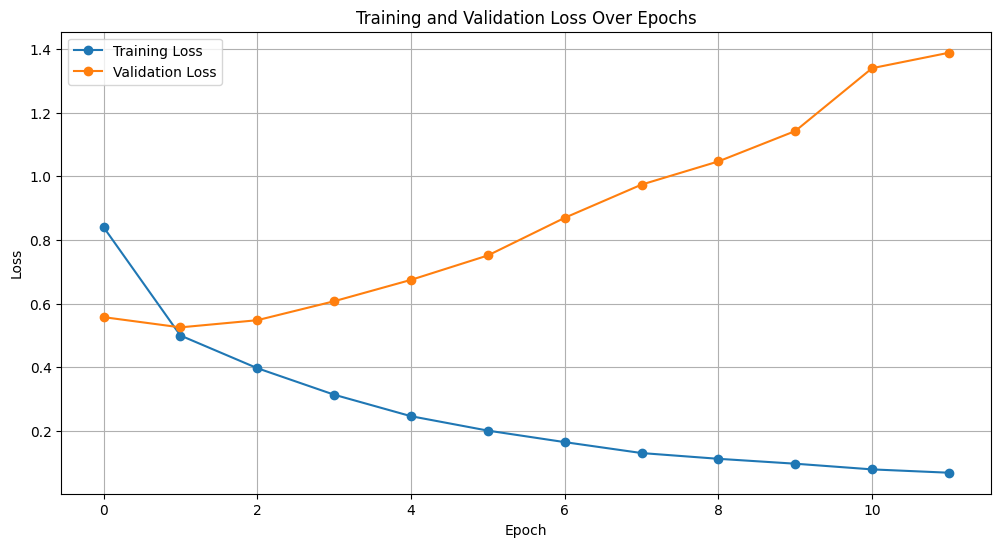


Final model saved as 'final_cnn_model.h5'


In [8]:
# ========================================
# Import Necessary Libraries
# ========================================
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import optuna
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import (
    cohen_kappa_score,
    classification_report,
    f1_score,
    roc_auc_score,
    precision_recall_curve
)
from sklearn.utils import class_weight
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Embedding,
    Conv1D,
    MaxPooling1D,
    GlobalAveragePooling1D,
    Dense,
    Dropout
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

# ========================================
# 1. Set Seeds for Reproducibility
# ========================================
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    # For TensorFlow 2.x, setting the following is also recommended
    tf.keras.utils.set_random_seed(seed)

set_seeds(42)

# ========================================
# 2. Data Preprocessing
# ========================================
# Assuming 'data_cleaned' is your DataFrame containing 'resume' and 'label_list' columns
# Replace this with your actual data loading method
# Example:
# data_cleaned = pd.read_csv('your_data.csv')

# Convert label_list to proper multi-label format
mlb = MultiLabelBinarizer()
y = data_cleaned['label_list']
one_hot_labels = mlb.fit_transform(y)
num_classes = one_hot_labels.shape[1]

print("\nClasses:", mlb.classes_)
print("One-Hot Encoded Labels Shape:", one_hot_labels.shape)

# Tokenize the resumes
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(data_cleaned['resume'])
sequences = tokenizer.texts_to_sequences(data_cleaned['resume'])
max_sequence_length = 100
X_features = pad_sequences(
    sequences, maxlen=max_sequence_length, padding='post', truncating='post'
)

print("\nTokenized and Padded Sequences Shape:", X_features.shape)

# ========================================
# 3. Stratified Data Splitting
# ========================================
# Initialize MultilabelStratifiedShuffleSplit for Train and Temp (40%)
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
train_idx, temp_idx = next(msss.split(X_features, one_hot_labels))

X_train, y_train = X_features[train_idx], one_hot_labels[train_idx]
X_temp, y_temp = X_features[temp_idx], one_hot_labels[temp_idx]

# Initialize MultilabelStratifiedShuffleSplit for Validation and Test (each 50% of Temp)
msss_val_test = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx_rel, test_idx_rel = next(msss_val_test.split(X_temp, y_temp))

# Map relative indices back to absolute indices
val_idx = temp_idx[val_idx_rel]
test_idx = temp_idx[test_idx_rel]

X_val, y_val = X_features[val_idx], one_hot_labels[val_idx]
X_test, y_test = X_features[test_idx], one_hot_labels[test_idx]

print("\nTraining Samples:", X_train.shape[0])
print("Validation Samples:", X_val.shape[0])
print("Test Samples:", X_test.shape[0])

# ========================================
# 4. Compute Class Weights
# ========================================
# Compute class weights for each class
class_weights = {}

for i in range(num_classes):
    y_i = y_train[:, i]
    weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.array([0, 1]),
        y=y_i
    )
    class_weights[i] = weights[1]  # Weight for class '1'

print("\nClass Weights:", class_weights)

# ========================================
# 5. Define the Custom Loss Function
# ========================================
def weighted_binary_crossentropy(class_weights):
    """
    Custom weighted binary cross-entropy loss function.
    
    Parameters:
        class_weights (dict): Dictionary mapping class indices to their respective weights.
    
    Returns:
        function: Weighted binary cross-entropy loss function.
    """
    def loss(y_true, y_pred):
        # Cast y_true to float32
        y_true = K.cast(y_true, dtype='float32')

        # Compute binary cross-entropy
        bce = K.binary_crossentropy(y_true, y_pred)

        # Create a tensor of class weights
        weights = K.constant([class_weights[i] for i in range(num_classes)], dtype='float32')

        # Multiply by class weights
        weighted_bce = bce * weights

        # Return mean loss over classes
        return K.mean(weighted_bce, axis=-1)

    return loss

# ========================================
# 6. Define Functions for Hyperparameter Tuning and Training
# ========================================
def objective(trial):
    # Suggest values for the hyperparameters
    embedding_dim = trial.suggest_int('embedding_dim', 50, 200, step=50)
    num_filters = trial.suggest_int('num_filters', 64, 256, step=64)
    kernel_size = trial.suggest_int('kernel_size', 3, 9, step=2)
    dense_units = trial.suggest_int('dense_units', 64, 256, step=64)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5, step=0.1)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)

    # Create the CNN model
    model = Sequential([
        Embedding(input_dim=10000, output_dim=embedding_dim, input_length=max_sequence_length),
        Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu'),
        MaxPooling1D(pool_size=2),
        GlobalAveragePooling1D(),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(num_classes, activation='sigmoid')  # For multi-label classification
    ])

    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss=weighted_binary_crossentropy(class_weights),
        metrics=['accuracy']
    )

    # Callbacks for early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=0
    )
    model_checkpoint = ModelCheckpoint(
        'trial_best_model.h5',
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=0
    )

    # Train the model
    history = model.fit(
        X_train, y_train,
        batch_size=32,
        epochs=50,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, model_checkpoint],
        verbose=0  # Turn off verbose output for cleaner Optuna logs
    )

    # Return the best validation loss from the training process
    return min(history.history['val_loss'])

# ========================================
# 7. Run the Optuna Study
# ========================================
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# Print the best hyperparameters found
print("\nBest Hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"{key}: {value}")

# ========================================
# 8. Train the Final Model with Best Hyperparameters
# ========================================
def train_final_model(best_params):
    model = Sequential([
        Embedding(input_dim=10000, output_dim=best_params['embedding_dim'], input_length=max_sequence_length),
        Conv1D(filters=best_params['num_filters'], kernel_size=best_params['kernel_size'], activation='relu'),
        MaxPooling1D(pool_size=2),
        GlobalAveragePooling1D(),
        Dense(best_params['dense_units'], activation='relu'),
        Dropout(best_params['dropout_rate']),
        Dense(num_classes, activation='sigmoid')
    ])

    # Compile the model
    optimizer = Adam(learning_rate=best_params['learning_rate'])
    model.compile(
        optimizer=optimizer,
        loss=weighted_binary_crossentropy(class_weights),
        metrics=[]
    )

    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    model_checkpoint = ModelCheckpoint(
        'best_cnn_model_optuna.h5',
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )

    # Train the model
    model.fit(
        X_train, y_train,
        batch_size=32,
        epochs=100,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, model_checkpoint],
        verbose=1
    )

    return model

# Train the final model using the best parameters
best_params = study.best_trial.params
final_model = train_final_model(best_params)

# Load the best model from file
final_model = load_model('best_cnn_model_optuna.h5', compile=False)
final_model.compile(
    optimizer=Adam(learning_rate=best_params['learning_rate']),
    loss=weighted_binary_crossentropy(class_weights),
    metrics=[]
)

# ========================================
# 9. Define Functions for Evaluation
# ========================================
def compute_optimal_thresholds(y_true, y_scores):
    num_classes = y_true.shape[1]
    optimal_thresholds = np.zeros(num_classes)
    
    for i in range(num_classes):
        y_true_class = y_true[:, i]
        y_scores_class = y_scores[:, i]
        
        if np.sum(y_true_class) == 0:
            optimal_thresholds[i] = 1.0
            continue
        
        precision, recall, thresholds = precision_recall_curve(y_true_class, y_scores_class)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        f1_scores = np.nan_to_num(f1_scores)
        index = np.argmax(f1_scores)
        if index < len(thresholds):
            optimal_threshold = thresholds[index]
        else:
            optimal_threshold = thresholds[-1]
        optimal_thresholds[i] = optimal_threshold
    
    return optimal_thresholds

def apply_thresholds(y_scores, thresholds):
    return (y_scores >= thresholds).astype(int)

def evaluate_model_with_thresholds(model, X_val, y_val, X_test, y_test, mlb, dataset_name_val="Validation", dataset_name_test="Test"):
    y_val_pred_probs = model.predict(X_val)
    optimal_thresholds = compute_optimal_thresholds(y_val, y_val_pred_probs)
    print("\nOptimal Thresholds per Class:")
    for idx, threshold in enumerate(optimal_thresholds):
        print(f"Class '{mlb.classes_[idx]}': {threshold:.4f}")
    
    y_val_pred = apply_thresholds(y_val_pred_probs, optimal_thresholds)
    print(f"\nClassification Report ({dataset_name_val} Set) with Optimal Thresholds:")
    print(classification_report(y_val, y_val_pred, target_names=mlb.classes_, zero_division=0))
    kappa_val = cohen_kappa_score(y_val.flatten(), y_val_pred.flatten())
    print(f"Cohen's Kappa Score ({dataset_name_val} Set): {kappa_val:.4f}")
    weighted_f1_val = f1_score(y_val, y_val_pred, average='weighted')
    print(f"Weighted F1-Score ({dataset_name_val} Set): {weighted_f1_val:.4f}")
    try:
        auc_val = roc_auc_score(y_val, y_val_pred_probs, average='macro')
        print(f"ROC AUC Score ({dataset_name_val} Set): {auc_val:.4f}")
    except ValueError as e:
        print(f"ROC AUC Score ({dataset_name_val} Set) could not be computed: {e}")
    
    y_test_pred_probs = model.predict(X_test)
    y_test_pred = apply_thresholds(y_test_pred_probs, optimal_thresholds)
    print(f"\nClassification Report ({dataset_name_test} Set) with Optimal Thresholds:")
    print(classification_report(y_test, y_test_pred, target_names=mlb.classes_, zero_division=0))
    kappa_test = cohen_kappa_score(y_test.flatten(), y_test_pred.flatten())
    print(f"Cohen's Kappa Score ({dataset_name_test} Set): {kappa_test:.4f}")
    weighted_f1_test = f1_score(y_test, y_test_pred, average='weighted')
    print(f"Weighted F1-Score ({dataset_name_test} Set): {weighted_f1_test:.4f}")
    try:
        auc_test = roc_auc_score(y_test, y_test_pred_probs, average='macro')
        print(f"ROC AUC Score ({dataset_name_test} Set): {auc_test:.4f}")
    except ValueError as e:
        print(f"ROC AUC Score ({dataset_name_test} Set) could not be computed: {e}")

# ========================================
# 10. Evaluate the Final Model
# ========================================
evaluate_model_with_thresholds(
    model=final_model,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    mlb=mlb
)

# ========================================
# 11. Visualize Training History (Optional)
# ========================================
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# ========================================
# 12. Save the Final Model (Optional)
# ========================================
final_model.save('final_cnn_model.h5')
print("\nFinal model saved as 'final_cnn_model.h5'")


## Hyperparameter tuning Optuna (PyTorch)

In [ ]:
# ========================================
# Import Necessary Libraries
# ========================================
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import (
    classification_report,
    cohen_kappa_score,
    f1_score,
    roc_auc_score
)
from sklearn.utils import class_weight
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import optuna
import matplotlib.pyplot as plt

# ========================================
# 1. Set Seeds for Reproducibility
# ========================================
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seeds(42)

# ========================================
# 2. Data Preprocessing
# ========================================
# Assuming 'data_cleaned' is your DataFrame with 'resume' and 'label_list' columns
# Example:
# data_cleaned = pd.read_csv('your_data.csv')

# Convert 'label_list' to multi-label binary format
mlb = MultiLabelBinarizer()
y = data_cleaned['label_list']
one_hot_labels = mlb.fit_transform(y)
num_classes = one_hot_labels.shape[1]

print("\nClasses:", mlb.classes_)
print("One-Hot Encoded Labels Shape:", one_hot_labels.shape)

# Tokenize the resumes
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(data_cleaned['resume'])
sequences = tokenizer.texts_to_sequences(data_cleaned['resume'])
max_sequence_length = 100
X_features = pad_sequences(
    sequences, maxlen=max_sequence_length, padding='post', truncating='post'
)

print("\nTokenized and Padded Sequences Shape:", X_features.shape)

# ========================================
# 3. Stratified Data Splitting
# ========================================
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
train_idx, temp_idx = next(msss.split(X_features, one_hot_labels))

X_train, y_train = X_features[train_idx], one_hot_labels[train_idx]
X_temp, y_temp = X_features[temp_idx], one_hot_labels[temp_idx]

msss_val_test = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx_rel, test_idx_rel = next(msss_val_test.split(X_temp, y_temp))

# Map relative indices back to absolute indices
val_idx = temp_idx[val_idx_rel]
test_idx = temp_idx[test_idx_rel]

X_val, y_val = X_features[val_idx], one_hot_labels[val_idx]
X_test, y_test = X_features[test_idx], one_hot_labels[test_idx]

print("\nTraining Samples:", X_train.shape[0])
print("Validation Samples:", X_val.shape[0])
print("Test Samples:", X_test.shape[0])

# ========================================
# 4. Compute Class Weights
# ========================================
# Compute class weights for each class based on the training set
class_weights_list = []
for i in range(num_classes):
    y_i = y_train[:, i]
    # Compute class weights using sklearn's compute_class_weight
    weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.array([0, 1]),
        y=y_i
    )
    class_weights_list.append(weights[1])  # Weight for class '1'

class_weights_tensor = torch.tensor(class_weights_list, dtype=torch.float)

print("\nClass Weights:", class_weights_list)

# ========================================
# 5. Define Custom Dataset
# ========================================
class ResumeDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.float)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create Dataset instances
train_dataset = ResumeDataset(X_train, y_train)
val_dataset = ResumeDataset(X_val, y_val)
test_dataset = ResumeDataset(X_test, y_test)

# ========================================
# 6. Define DataLoaders
# ========================================
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ========================================
# 7. Define the CNN Model in PyTorch
# ========================================
class CNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, num_filters, kernel_size, dense_units, dropout_rate):
        super(CNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.conv1 = nn.Conv1d(in_channels=embed_dim, out_channels=num_filters, kernel_size=kernel_size)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(num_filters, dense_units)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(dense_units, num_classes)

    def forward(self, x):
        # x: (batch_size, max_sequence_length)
        x = self.embedding(x)  # (batch_size, max_sequence_length, embed_dim)
        x = x.permute(0, 2, 1)  # (batch_size, embed_dim, max_sequence_length)
        x = F.relu(self.conv1(x))  # (batch_size, num_filters, L_out)
        x = self.pool(x)  # (batch_size, num_filters, L_out//2)
        x = self.global_avg_pool(x).squeeze(2)  # (batch_size, num_filters)
        x = F.relu(self.fc1(x))  # (batch_size, dense_units)
        x = self.dropout(x)
        logits = self.fc2(x)  # (batch_size, num_classes)
        return logits

# ========================================
# 8. Define Hyperparameter Tuning with Optuna
# ========================================
def objective(trial):
    # Suggest hyperparameters
    embed_dim = trial.suggest_int('embed_dim', 50, 200, step=50)
    num_filters = trial.suggest_int('num_filters', 64, 256, step=64)
    kernel_size = trial.suggest_int('kernel_size', 3, 9, step=2)
    dense_units = trial.suggest_int('dense_units', 64, 256, step=64)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5, step=0.1)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)

    vocab_size = 10000  # As defined in Tokenizer
    num_classes_local = num_classes

    # Instantiate the model
    model = CNN(
        vocab_size=vocab_size,
        embed_dim=embed_dim,
        num_classes=num_classes_local,
        num_filters=num_filters,
        kernel_size=kernel_size,
        dense_units=dense_units,
        dropout_rate=dropout_rate
    )

    # Move model to device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Define loss and optimizer
    criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor.to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Early stopping parameters
    patience = 5
    best_val_loss = float('inf')
    patience_counter = 0

    max_epochs = 50  # Reduced epochs for tuning

    for epoch in range(max_epochs):
        # Training
        model.train()
        train_losses = []
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        
        avg_train_loss = np.mean(train_losses)

        # Validation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_losses.append(loss.item())
        avg_val_loss = np.mean(val_losses)

        # Report intermediate objective value
        trial.report(avg_val_loss, epoch)

        # Handle pruning based on the intermediate value
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            break

    return best_val_loss

# Create and run the Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# Print the best hyperparameters found
print("\nBest Hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"{key}: {value}")

# ========================================
# 9. Train Final Model with Best Hyperparameters
# ========================================
def train_final_model(best_params):
    embed_dim = best_params['embed_dim']
    num_filters = best_params['num_filters']
    kernel_size = best_params['kernel_size']
    dense_units = best_params['dense_units']
    dropout_rate = best_params['dropout_rate']
    learning_rate = best_params['learning_rate']

    vocab_size = 10000  # As defined in Tokenizer
    num_classes_local = num_classes

    # Instantiate the model
    model = CNN(
        vocab_size=vocab_size,
        embed_dim=embed_dim,
        num_classes=num_classes_local,
        num_filters=num_filters,
        kernel_size=kernel_size,
        dense_units=dense_units,
        dropout_rate=dropout_rate
    )

    # Move model to device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Define loss and optimizer
    criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor.to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Early stopping and checkpoint
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    max_epochs = 200  # Increased epochs for final training

    best_model_state = None

    for epoch in range(max_epochs):
        # Training
        model.train()
        train_losses = []
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        
        avg_train_loss = np.mean(train_losses)

        # Validation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_losses.append(loss.item())
        avg_val_loss = np.mean(val_losses)

        print(f'Epoch: {epoch+1:03d}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        # Check for improvement
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
            torch.save(best_model_state, 'best_cnn_model.pth')
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Load the best model
    model.load_state_dict(torch.load('best_cnn_model.pth'))
    return model

# Train the final model using the best parameters
final_model = train_final_model(study.best_trial.params)

# ========================================
# 10. Define Functions for Threshold Tuning and Evaluation
# ========================================
def compute_optimal_thresholds(y_true, y_scores):
    """
    Computes the optimal threshold for each class to maximize the F1-score.
    
    Parameters:
        y_true (numpy.ndarray): True binary labels of shape (num_samples, num_classes).
        y_scores (numpy.ndarray): Predicted probabilities of shape (num_samples, num_classes).
    
    Returns:
        numpy.ndarray: Array of optimal thresholds for each class.
    """
    num_classes = y_true.shape[1]
    optimal_thresholds = np.zeros(num_classes)
    
    for i in range(num_classes):
        y_true_class = y_true[:, i]
        y_scores_class = y_scores[:, i]
        
        # Only compute thresholds if there are positive samples
        if np.sum(y_true_class) == 0:
            optimal_thresholds[i] = 1.0
            continue
        
        precision, recall, thresholds = precision_recall_curve(y_true_class, y_scores_class)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        f1_scores = np.nan_to_num(f1_scores)
        index = np.argmax(f1_scores)
        if index < len(thresholds):
            optimal_threshold = thresholds[index]
        else:
            optimal_threshold = thresholds[-1]
        optimal_thresholds[i] = optimal_threshold
    
    return optimal_thresholds

def apply_thresholds(y_scores, thresholds):
    """
    Applies the optimal thresholds to the predicted probabilities.
    
    Parameters:
        y_scores (numpy.ndarray): Predicted probabilities of shape (num_samples, num_classes).
        thresholds (numpy.ndarray): Optimal thresholds for each class of shape (num_classes,).
    
    Returns:
        numpy.ndarray: Binary predictions after applying thresholds.
    """
    return (y_scores >= thresholds).astype(int)

def evaluate_model(model, loader, device):
    """
    Evaluates the model on a given DataLoader.
    
    Parameters:
        model (nn.Module): Trained PyTorch model.
        loader (DataLoader): DataLoader for the dataset to evaluate.
        device (torch.device): Device to run the evaluation on.
    
    Returns:
        tuple: Tuple containing true labels and predicted probabilities.
    """
    model.eval()
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for batch_X, batch_y in loader:
            batch_X = batch_X.to(device)
            outputs = model(batch_X)
            probs = torch.sigmoid(outputs).cpu().numpy()
            all_probs.append(probs)
            all_labels.append(batch_y.numpy())
    all_labels = np.vstack(all_labels)
    all_probs = np.vstack(all_probs)
    return all_labels, all_probs

# ========================================
# 11. Evaluate the Final Model with Threshold Tuning
# ========================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Get validation predictions
val_labels, val_probs = evaluate_model(final_model, val_loader, device)

# Compute optimal thresholds based on validation set
optimal_thresholds = compute_optimal_thresholds(val_labels, val_probs)
print("\nOptimal Thresholds per Class:")
for idx, threshold in enumerate(optimal_thresholds):
    print(f"Class '{mlb.classes_[idx]}': {threshold:.4f}")

# Apply thresholds to validation predictions
val_preds = apply_thresholds(val_probs, optimal_thresholds)

# Print Classification Report for Validation Set
print("\nClassification Report (Validation Set) with Optimal Thresholds:")
print(classification_report(val_labels, val_preds, target_names=mlb.classes_, zero_division=0))

# Calculate Cohen's Kappa Score for Validation Set
kappa_val = cohen_kappa_score(val_labels.flatten(), val_preds.flatten())
print(f"Cohen's Kappa Score (Validation Set): {kappa_val:.4f}")

# Calculate Weighted F1-Score for Validation Set
weighted_f1_val = f1_score(val_labels, val_preds, average='weighted')
print(f"Weighted F1-Score (Validation Set): {weighted_f1_val:.4f}")

# Calculate ROC AUC Score for Validation Set
try:
    auc_val = roc_auc_score(val_labels, val_probs, average='macro')
    print(f"ROC AUC Score (Validation Set): {auc_val:.4f}")
except ValueError as e:
    print(f"ROC AUC Score (Validation Set) could not be computed: {e}")

# Get test predictions
test_labels, test_probs = evaluate_model(final_model, test_loader, device)

# Apply the same thresholds to test predictions
test_preds = apply_thresholds(test_probs, optimal_thresholds)

# Print Classification Report for Test Set
print("\nClassification Report (Test Set) with Optimal Thresholds:")
print(classification_report(test_labels, test_preds, target_names=mlb.classes_, zero_division=0))

# Calculate Cohen's Kappa Score for Test Set
kappa_test = cohen_kappa_score(test_labels.flatten(), test_preds.flatten())
print(f"Cohen's Kappa Score (Test Set): {kappa_test:.4f}")

# Calculate Weighted F1-Score for Test Set
weighted_f1_test = f1_score(test_labels, test_preds, average='weighted')
print(f"Weighted F1-Score (Test Set): {weighted_f1_test:.4f}")

# Calculate ROC AUC Score for Test Set
try:
    auc_test = roc_auc_score(test_labels, test_probs, average='macro')
    print(f"ROC AUC Score (Test Set): {auc_test:.4f}")
except ValueError as e:
    print(f"ROC AUC Score (Test Set) could not be computed: {e}")

# ========================================
# 12. Visualize Training History (Optional)
# ========================================
# Note: Since we used a separate training loop in the objective function,
# we don't have access to the training history for each trial.
# To visualize training history, you might need to modify the training loop to store losses.

# Alternatively, you can visualize training loss from the final training loop.
# Here's an example assuming you stored training and validation losses.

# Example:
# (Uncomment and modify if you have access to training history)

# plt.figure(figsize=(12, 6))
# plt.plot(train_losses, label='Training Loss', marker='o')
# plt.plot(val_losses, label='Validation Loss', marker='o')
# plt.title('Training and Validation Loss Over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.grid(True)
# plt.show()

# ========================================
# 13. Save the Final Model (Optional)
# ========================================
torch.save(final_model.state_dict(), 'final_cnn_model.pth')
print("\nFinal model saved as 'final_cnn_model.pth'")


# Final model (w/o threshold tuning)

In [2]:
# ========================================
# Import Necessary Libraries
# ========================================
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import (
    cohen_kappa_score,
    classification_report,
    f1_score,
    roc_auc_score
)
from sklearn.utils import class_weight
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Embedding,
    Conv1D,
    MaxPooling1D,
    GlobalAveragePooling1D,
    Dense,
    Dropout
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

# ========================================
# 1. Set Seeds for Reproducibility
# ========================================
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    # For TensorFlow 2.x, setting the following is also recommended
    tf.keras.utils.set_random_seed(seed)

set_seeds(42)

# ========================================
# 2. Data Preprocessing
# ========================================
# Assuming 'data_cleaned' is your DataFrame with 'resume' and 'label_list' columns

# Convert label_list to proper multi-label format
mlb = MultiLabelBinarizer()
y = data_cleaned['label_list']
one_hot_labels = mlb.fit_transform(y)
num_classes = one_hot_labels.shape[1]

print("\nClasses:", mlb.classes_)
print("One-Hot Encoded Labels Shape:", one_hot_labels.shape)

# Tokenize the resumes
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(data_cleaned['resume'])
sequences = tokenizer.texts_to_sequences(data_cleaned['resume'])
max_sequence_length = 100
X_features = pad_sequences(
    sequences, maxlen=max_sequence_length, padding='post', truncating='post'
)

print("\nTokenized and Padded Sequences Shape:", X_features.shape)

# ========================================
# 3. Stratified Data Splitting
# ========================================
# Initialize MultilabelStratifiedShuffleSplit for Train and Temp (40%)
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
train_idx, temp_idx = next(msss.split(X_features, one_hot_labels))

X_train, y_train = X_features[train_idx], one_hot_labels[train_idx]
X_temp, y_temp = X_features[temp_idx], one_hot_labels[temp_idx]

# Initialize MultilabelStratifiedShuffleSplit for Validation and Test (each 50% of Temp)
msss_val_test = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx_rel, test_idx_rel = next(msss_val_test.split(X_temp, y_temp))

# Map relative indices back to absolute indices
val_idx = temp_idx[val_idx_rel]
test_idx = temp_idx[test_idx_rel]

X_val, y_val = X_features[val_idx], one_hot_labels[val_idx]
X_test, y_test = X_features[test_idx], one_hot_labels[test_idx]

print("\nTraining Samples:", X_train.shape[0])
print("Validation Samples:", X_val.shape[0])
print("Test Samples:", X_test.shape[0])

# ========================================
# 4. Compute Class Weights
# ========================================
# Compute class weights for each class
class_weights = {}

for i in range(num_classes):
    y_i = y_train[:, i]
    weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.array([0, 1]),
        y=y_i
    )
    class_weights[i] = weights[1]  # Weight for class '1'

print("\nClass Weights:", class_weights)

# ========================================
# 5. Define the Custom Loss Function
# ========================================
def weighted_binary_crossentropy(class_weights):

    def loss(y_true, y_pred):
        # Cast y_true to float32
        y_true = K.cast(y_true, dtype='float32')

        # Compute binary cross-entropy
        bce = K.binary_crossentropy(y_true, y_pred)

        # Multiply by class weights
        weights = K.constant([class_weights[i] for i in range(num_classes)], dtype='float32')
        weighted_bce = bce * weights

        # Return mean loss over classes
        return K.mean(weighted_bce, axis=-1)

    return loss

# ========================================
# 6. Define the CNN Model with Best Hyperparameters
# ========================================
model = Sequential([
    Embedding(input_dim=10000, output_dim=100, input_length=max_sequence_length),
    Conv1D(filters=128, kernel_size=7, activation='relu'),
    MaxPooling1D(pool_size=5),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='sigmoid')  # For multi-label classification
])

# Compile the model with the custom loss function
optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss=weighted_binary_crossentropy(class_weights),
    metrics=[]  # You can add metrics like 'accuracy' if desired
)

# Display the model summary
model.summary()

# ========================================
# 7. Set Up Callbacks
# ========================================
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_cnn_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# ========================================
# 8. Train the Model
# ========================================
batch_size = 32
epochs = 50

history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# ========================================
# 9. Load the Best Model
# ========================================
best_model = load_model('best_cnn_model.h5', compile=False)

# Compile the model with the custom loss
best_model.compile(
    optimizer=optimizer,
    loss=weighted_binary_crossentropy(class_weights),
    metrics=[]
)

print("\nLoaded Best Model Summary:")
best_model.summary()

# ========================================
# 10. Evaluate the Model
# ========================================
def evaluate_model(model, X, y, mlb, dataset_name="Validation"):
    # Predict probabilities
    y_pred_probs = model.predict(X)
    
    # Convert probabilities to binary predictions (threshold=0.5)
    y_pred = (y_pred_probs >= 0.5).astype(int)
    
    # Calculate Cohen's Kappa Score
    kappa = cohen_kappa_score(y.flatten(), y_pred.flatten())
    print(f"\nCohen's Kappa Score ({dataset_name} Set): {kappa:.4f}")
    
    # Classification Report
    print(f"\nClassification Report ({dataset_name} Set):")
    print(classification_report(y, y_pred, target_names=mlb.classes_, zero_division=0))
    
    # Calculate Weighted F1-Score
    weighted_f1 = f1_score(y, y_pred, average='weighted')
    print(f"Weighted F1-Score ({dataset_name} Set): {weighted_f1:.4f}")
    
    # Calculate ROC AUC Score
    try:
        auc = roc_auc_score(y, y_pred_probs, average='macro')
        print(f"ROC AUC Score ({dataset_name} Set): {auc:.4f}")
    except ValueError as e:
        print(f"ROC AUC Score ({dataset_name} Set) could not be computed: {e}")

# Evaluate on Validation Set
print("\nEvaluating on the Validation Set:")
evaluate_model(best_model, X_val, y_val, mlb, dataset_name="Validation")

# Evaluate on Test Set
print("\nEvaluating on the Test Set:")
evaluate_model(best_model, X_test, y_test, mlb, dataset_name="Test")

# ========================================
# 11. Visualize Training History (Optional)
# ========================================
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# ========================================
# 12. Save the Final Model (Optional)
# ========================================
best_model.save('final_cnn_model.h5')
print("\nFinal model saved as 'final_cnn_model.h5'")


2024-11-10 12:57:19.597530: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-10 12:57:19.740516: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-10 12:57:19.747632: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-11-10 12:57:19.747648: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

KeyboardInterrupt: 

# Threshold tuning

In [2]:
# ========================================
# Import Necessary Libraries
# ========================================
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import (
    cohen_kappa_score,
    classification_report,
    f1_score,
    roc_auc_score,
    precision_recall_curve
)
from sklearn.utils import class_weight
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Embedding,
    Conv1D,
    MaxPooling1D,
    GlobalAveragePooling1D,
    Dense,
    Dropout
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

# ========================================
# 1. Set Seeds for Reproducibility
# ========================================
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    # For TensorFlow 2.x, setting the following is also recommended
    tf.keras.utils.set_random_seed(seed)

set_seeds(42)

# ========================================
# 2. Data Preprocessing
# ========================================
# Assuming 'data_cleaned' is your DataFrame containing 'resume' and 'label_list' columns
# Replace this with your actual data loading method
# Example:
# data_cleaned = pd.read_csv('your_data.csv')

# Convert label_list to proper multi-label format
mlb = MultiLabelBinarizer()
y = data_cleaned['label_list']
one_hot_labels = mlb.fit_transform(y)
num_classes = one_hot_labels.shape[1]

print("\nClasses:", mlb.classes_)
print("One-Hot Encoded Labels Shape:", one_hot_labels.shape)

# Tokenize the resumes
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(data_cleaned['resume'])
sequences = tokenizer.texts_to_sequences(data_cleaned['resume'])
max_sequence_length = 100
X_features = pad_sequences(
    sequences, maxlen=max_sequence_length, padding='post', truncating='post'
)

print("\nTokenized and Padded Sequences Shape:", X_features.shape)

# ========================================
# 3. Stratified Data Splitting
# ========================================
# Initialize MultilabelStratifiedShuffleSplit for Train and Temp (40%)
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
train_idx, temp_idx = next(msss.split(X_features, one_hot_labels))

X_train, y_train = X_features[train_idx], one_hot_labels[train_idx]
X_temp, y_temp = X_features[temp_idx], one_hot_labels[temp_idx]

# Initialize MultilabelStratifiedShuffleSplit for Validation and Test (each 50% of Temp)
msss_val_test = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx_rel, test_idx_rel = next(msss_val_test.split(X_temp, y_temp))

# Map relative indices back to absolute indices
val_idx = temp_idx[val_idx_rel]
test_idx = temp_idx[test_idx_rel]

X_val, y_val = X_features[val_idx], one_hot_labels[val_idx]
X_test, y_test = X_features[test_idx], one_hot_labels[test_idx]

print("\nTraining Samples:", X_train.shape[0])
print("Validation Samples:", X_val.shape[0])
print("Test Samples:", X_test.shape[0])

# ========================================
# 4. Compute Class Weights
# ========================================
# Compute class weights for each class
class_weights = {}

for i in range(num_classes):
    y_i = y_train[:, i]
    weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.array([0, 1]),
        y=y_i
    )
    class_weights[i] = weights[1]  # Weight for class '1'

print("\nClass Weights:", class_weights)

# ========================================
# 5. Define the Custom Loss Function
# ========================================
def weighted_binary_crossentropy(class_weights):
    """
    Custom weighted binary cross-entropy loss function.
    
    Parameters:
        class_weights (dict): Dictionary mapping class indices to their respective weights.
    
    Returns:
        function: Weighted binary cross-entropy loss function.
    """
    def loss(y_true, y_pred):
        # Cast y_true to float32
        y_true = K.cast(y_true, dtype='float32')

        # Compute binary cross-entropy
        bce = K.binary_crossentropy(y_true, y_pred)

        # Create a tensor of class weights
        weights = K.constant([class_weights[i] for i in range(num_classes)], dtype='float32')

        # Multiply by class weights
        weighted_bce = bce * weights

        # Return mean loss over classes
        return K.mean(weighted_bce, axis=-1)

    return loss

# ========================================
# 6. Define the CNN Model with Best Hyperparameters
# ========================================
# You might want to perform hyperparameter tuning here.
# For simplicity, we're using predefined hyperparameters.

model = Sequential([
    Embedding(input_dim=10000, output_dim=100, input_length=max_sequence_length),
    Conv1D(filters=128, kernel_size=7, activation='relu'),
    MaxPooling1D(pool_size=5),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='sigmoid')  # For multi-label classification
])

# Compile the model with the custom loss function
optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss=weighted_binary_crossentropy(class_weights),
    metrics=[]  # You can add metrics like 'accuracy' if desired
)

# Display the model summary
model.summary()

# ========================================
# 7. Set Up Callbacks
# ========================================
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_cnn_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# ========================================
# 8. Train the Model
# ========================================
batch_size = 32
epochs = 50

history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# ========================================
# 9. Load the Best Model
# ========================================
best_model = load_model('best_cnn_model.h5', compile=False)

# Compile the model with the custom loss
best_model.compile(
    optimizer=optimizer,
    loss=weighted_binary_crossentropy(class_weights),
    metrics=[]
)

print("\nLoaded Best Model Summary:")
best_model.summary()

# ========================================
# 10. Define Functions to Compute and Apply Optimal Thresholds
# (Already Covered in Step 1)
# ========================================
def compute_optimal_thresholds(y_true, y_scores):
    """
    Computes the optimal threshold for each class to maximize the F1-score.
    
    Parameters:
        y_true (numpy.ndarray): True binary labels of shape (num_samples, num_classes).
        y_scores (numpy.ndarray): Predicted probabilities of shape (num_samples, num_classes).
    
    Returns:
        numpy.ndarray: Array of optimal thresholds for each class.
    """
    num_classes = y_true.shape[1]
    optimal_thresholds = np.zeros(num_classes)
    
    for i in range(num_classes):
        y_true_class = y_true[:, i]
        y_scores_class = y_scores[:, i]
        
        # Only compute thresholds if there are positive samples in y_true_class
        if np.sum(y_true_class) == 0:
            # No positive samples, set threshold to 1 to predict all zeros
            optimal_thresholds[i] = 1.0
            continue
        
        precision, recall, thresholds = precision_recall_curve(y_true_class, y_scores_class)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        # Replace NaN with zero
        f1_scores = np.nan_to_num(f1_scores)
        # Find the threshold that gives the maximum F1 score
        index = np.argmax(f1_scores)
        if index < len(thresholds):
            optimal_threshold = thresholds[index]
        else:
            optimal_threshold = thresholds[-1]
        optimal_thresholds[i] = optimal_threshold
    
    return optimal_thresholds

def apply_thresholds(y_scores, thresholds):
    """
    Applies the optimal thresholds to the predicted probabilities.
    
    Parameters:
        y_scores (numpy.ndarray): Predicted probabilities of shape (num_samples, num_classes).
        thresholds (numpy.ndarray): Optimal thresholds for each class of shape (num_classes,).
    
    Returns:
        numpy.ndarray: Binary predictions after applying thresholds.
    """
    return (y_scores >= thresholds).astype(int)
# ========================================
# Evaluation Function for Final Model
# ========================================
def evaluate_final_model(model, X_val, y_val, X_test, y_test, mlb):
    """
    Evaluates the CNN model on validation and test datasets.

    Parameters:
    - model: Trained Keras CNN model.
    - X_val (numpy.ndarray): Validation features.
    - y_val (numpy.ndarray): Validation true labels.
    - X_test (numpy.ndarray): Test features.
    - y_test (numpy.ndarray): Test true labels.
    - mlb: MultiLabelBinarizer instance used for label transformation.

    Returns:
    - None: Prints evaluation metrics.
    """
    # ==================================
    # 1. Obtain Predicted Probabilities
    # ==================================
    y_pred_val_probs = model.predict(X_val)
    y_pred_test_probs = model.predict(X_test)

    # =========================================
    # 2. Compute Optimal Thresholds (Validation)
    # =========================================
    optimal_thresholds = compute_optimal_thresholds(y_val, y_pred_val_probs)

    # =========================================
    # 3. Apply Thresholds to Obtain Binary Labels
    # =========================================
    y_pred_val = apply_thresholds(y_pred_val_probs, optimal_thresholds)
    y_pred_test = apply_thresholds(y_pred_test_probs, optimal_thresholds)

    # =========================================
    # 4. Evaluation Metrics for Validation Set
    # =========================================
    print("\n===== Validation Set Metrics =====")
    
    # Classification Report
    print("\nValidation Classification Report:")
    print(classification_report(y_val, y_pred_val, target_names=mlb.classes_, zero_division=0))
    
    # Weighted F1-score
    weighted_f1_val = f1_score(y_val, y_pred_val, average='weighted')
    print(f"Weighted F1-score (Validation Set): {weighted_f1_val:.4f}")
    
    # ROC AUC Scores
    try:
        auc_val_macro = roc_auc_score(y_val, y_pred_val_probs, average='macro')
        auc_val_micro = roc_auc_score(y_val, y_pred_val_probs, average='micro')
        auc_val_weighted = roc_auc_score(y_val, y_pred_val_probs, average='weighted')
        print(f"ROC AUC Score (Validation Set) - Macro Average: {auc_val_macro:.4f}")
        print(f"ROC AUC Score (Validation Set) - Micro Average: {auc_val_micro:.4f}")
        print(f"ROC AUC Score (Validation Set) - Weighted Average: {auc_val_weighted:.4f}")
    except ValueError as e:
        print(f"ROC AUC Score (Validation Set) could not be computed: {e}")
    
    # Cohen's Kappa Score (Per Class and Average)
    kappa_scores_val = []
    for i in range(num_classes):
        kappa = cohen_kappa_score(y_val[:, i], y_pred_val[:, i])
        kappa_scores_val.append(kappa)
    average_kappa_val = np.mean(kappa_scores_val)
    print(f"Average Cohen's Kappa Score (Validation Set): {average_kappa_val:.4f}")
        
    # =====================================
    # 5. Evaluation Metrics for Test Set
    # =====================================
    print("\n===== Test Set Metrics =====")
    
    # Classification Report
    print("\nTest Classification Report:")
    print(classification_report(y_test, y_pred_test, target_names=mlb.classes_, zero_division=0))
    
    # Weighted F1-score
    weighted_f1_test = f1_score(y_test, y_pred_test, average='weighted')
    print(f"Weighted F1-score (Test Set): {weighted_f1_test:.4f}")
    
    # ROC AUC Scores
    try:
        auc_test_macro = roc_auc_score(y_test, y_pred_test_probs, average='macro')
        auc_test_micro = roc_auc_score(y_test, y_pred_test_probs, average='micro')
        auc_test_weighted = roc_auc_score(y_test, y_pred_test_probs, average='weighted')
        print(f"ROC AUC Score (Test Set) - Macro Average: {auc_test_macro:.4f}")
        print(f"ROC AUC Score (Test Set) - Micro Average: {auc_test_micro:.4f}")
        print(f"ROC AUC Score (Test Set) - Weighted Average: {auc_test_weighted:.4f}")
    except ValueError as e:
        print(f"ROC AUC Score (Test Set) could not be computed: {e}")
    
    # Cohen's Kappa Score (Per Class and Average)
    kappa_scores_test = []
    for i in range(num_classes):
        kappa = cohen_kappa_score(y_test[:, i], y_pred_test[:, i])
        kappa_scores_test.append(kappa)
    average_kappa_test = np.mean(kappa_scores_test)
    print(f"Average Cohen's Kappa Score (Test Set): {average_kappa_test:.4f}")

# Evaluate the model with optimal thresholds
evaluate_final_model(
    model=best_model,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    mlb=mlb
)



2024-11-27 11:16:51.369690: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-27 11:16:51.518084: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-11-27 11:16:51.518166: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-11-27 11:16:51.539797: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-27 11:16:52.284437: W tensorflow/stream_executor/platform/de

# Reporting results

183/183 [==============================] - 2s 12ms/step

===== Training Set Metrics =====

Training Classification Report:
                        precision    recall  f1-score   support

Database_Administrator       0.98      0.83      0.90      1979
   Front_End_Developer       0.92      0.86      0.89      2386
        Java_Developer       0.92      0.82      0.87      1951
 Network_Administrator       0.81      0.77      0.79      2676
       Project_manager       0.92      0.79      0.85      2730
      Python_Developer       0.97      0.94      0.96      1702
      Security_Analyst       0.94      0.87      0.90      1813
    Software_Developer       0.98      0.93      0.96      9008
 Systems_Administrator       0.87      0.73      0.80      3581
         Web_Developer       0.66      0.83      0.74      3956

             micro avg       0.89      0.85      0.87     31782
             macro avg       0.90      0.84      0.86     31782
          weighted avg       0.90      0.85

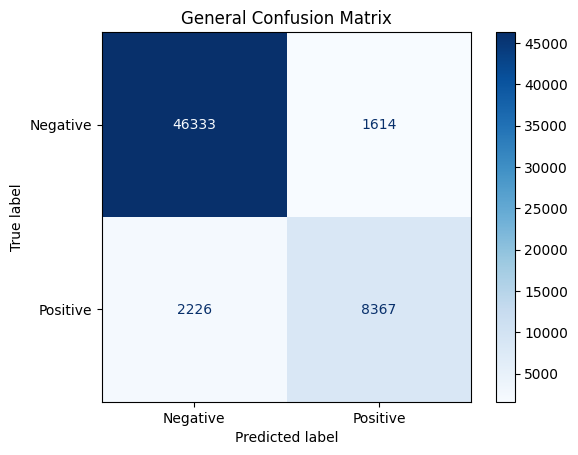


===== Test Set Metrics =====

Test Classification Report:
                        precision    recall  f1-score   support

Database_Administrator       0.91      0.72      0.80       660
   Front_End_Developer       0.86      0.76      0.81       795
        Java_Developer       0.85      0.73      0.79       650
 Network_Administrator       0.74      0.69      0.72       892
       Project_manager       0.81      0.69      0.74       910
      Python_Developer       0.90      0.85      0.88       567
      Security_Analyst       0.87      0.75      0.81       604
    Software_Developer       0.97      0.92      0.94      3002
 Systems_Administrator       0.81      0.70      0.75      1194
         Web_Developer       0.63      0.79      0.70      1319

             micro avg       0.84      0.79      0.81     10593
             macro avg       0.84      0.76      0.79     10593
          weighted avg       0.85      0.79      0.81     10593
           samples avg       0.84      0.82

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score, roc_auc_score, cohen_kappa_score
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

# Function to compute and plot a general confusion matrix
def plot_general_confusion_matrix(y_true, y_pred, model_name):
    """
    Plots a general confusion matrix for multi-label classification.

    Args:
        y_true (numpy.ndarray): Ground truth binary labels (flattened).
        y_pred (numpy.ndarray): Predicted binary labels (flattened).
        model_name (str): Name of the model for plot title.
    """
    # Flatten the arrays
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # Compute confusion matrix
    cm = confusion_matrix(y_true_flat, y_pred_flat)

    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"General Confusion Matrix")
    plt.savefig('CM_CNN.pdf')
    plt.show()

# Updated Evaluation Function for Train, Validation, and Test Sets
def evaluate_model_with_training_set(model, X_train, y_train, X_val, y_val, X_test, y_test, mlb):
    """
    Evaluates the CNN model on training, validation, and test datasets.

    Parameters:
    - model: Trained Keras CNN model.
    - X_train (numpy.ndarray): Training features.
    - y_train (numpy.ndarray): Training true labels.
    - X_val (numpy.ndarray): Validation features.
    - y_val (numpy.ndarray): Validation true labels.
    - X_test (numpy.ndarray): Test features.
    - y_test (numpy.ndarray): Test true labels.
    - mlb: MultiLabelBinarizer instance used for label transformation.

    Returns:
    - None: Prints evaluation metrics for all datasets.
    """
    # Obtain Predicted Probabilities
    y_pred_train_probs = model.predict(X_train)
    y_pred_val_probs = model.predict(X_val)
    y_pred_test_probs = model.predict(X_test)

    # Compute Optimal Thresholds (Validation)
    optimal_thresholds = compute_optimal_thresholds(y_val, y_pred_val_probs)

    # Apply Thresholds to Obtain Binary Labels
    y_pred_train = (y_pred_train_probs >= optimal_thresholds).astype(int)
    y_pred_val = (y_pred_val_probs >= optimal_thresholds).astype(int)
    y_pred_test = (y_pred_test_probs >= optimal_thresholds).astype(int)

    # Function to Evaluate a Dataset
    def evaluate_dataset(dataset_name, y_true, y_pred, y_probs):
        print(f"\n===== {dataset_name} Set Metrics =====")
        
        # Classification Report
        print(f"\n{dataset_name} Classification Report:")
        print(classification_report(y_true, y_pred, target_names=mlb.classes_, zero_division=0))
        
        # Weighted F1-score
        weighted_f1 = f1_score(y_true, y_pred, average='weighted')
        print(f"Weighted F1-score ({dataset_name} Set): {weighted_f1:.4f}")
        
        # ROC AUC Scores
        try:
            auc_weighted = roc_auc_score(y_true, y_probs, average='weighted')
            print(f"ROC AUC Score ({dataset_name} Set - Weighted Average): {auc_weighted:.4f}")
        except ValueError as e:
            print(f"ROC AUC Score ({dataset_name} Set) could not be computed: {e}")
            auc_weighted = None

        # Cohen's Kappa Score (Per Class and Average)
        kappa_scores = [cohen_kappa_score(y_true[:, i], y_pred[:, i]) for i in range(y_true.shape[1])]
        average_kappa = np.mean(kappa_scores)
        print(f"Average Cohen's Kappa Score ({dataset_name} Set): {average_kappa:.4f}")

        return {
            "Weighted F1": weighted_f1,
            "ROC AUC Weighted": auc_weighted,
            "Average Kappa": average_kappa,
        }

    # Evaluate on Training and Validation Sets
    train_metrics = evaluate_dataset("Training", y_train, y_pred_train, y_pred_train_probs)
    val_metrics = evaluate_dataset("Validation", y_val, y_pred_val, y_pred_val_probs)
    
    # Evaluate on Test Set with Confusion Matrix
    print("\n--- General Confusion Matrix (Test Set) ---")
    plot_general_confusion_matrix(y_test, y_pred_test, "Test Set")
    test_metrics = evaluate_dataset("Test", y_test, y_pred_test, y_pred_test_probs)

    # Summary of Results
    print("\n===== Summary of Metrics =====")
    print(f"Training Set - Weighted F1: {train_metrics['Weighted F1']:.4f}, "
          f"Weighted ROC AUC: {train_metrics['ROC AUC Weighted']:.4f}, "
          f"Average Kappa: {train_metrics['Average Kappa']:.4f}")
    print(f"Validation Set - Weighted F1: {val_metrics['Weighted F1']:.4f}, "
          f"Weighted ROC AUC: {val_metrics['ROC AUC Weighted']:.4f}, "
          f"Average Kappa: {val_metrics['Average Kappa']:.4f}")
    print(f"Test Set - Weighted F1: {test_metrics['Weighted F1']:.4f}, "
          f"Weighted ROC AUC: {test_metrics['ROC AUC Weighted']:.4f}, "
          f"Average Kappa: {test_metrics['Average Kappa']:.4f}")

# Example usage
# Assuming knn_pipeline, SVC_pipeline, cnn_model, X_train, y_train, X_val, y_val, X_test, y_test, mlb, best_thresholds, and optimal_thresholds are defined
evaluate_model_with_training_set(
    model=best_model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    mlb=mlb
)


In [5]:
# ========================================
# Updated Evaluation Function for Train, Validation, and Test Sets
# ========================================
def evaluate_model_with_training_set(model, X_train, y_train, X_val, y_val, X_test, y_test, mlb):
    """
    Evaluates the CNN model on training, validation, and test datasets.

    Parameters:
    - model: Trained Keras CNN model.
    - X_train (numpy.ndarray): Training features.
    - y_train (numpy.ndarray): Training true labels.
    - X_val (numpy.ndarray): Validation features.
    - y_val (numpy.ndarray): Validation true labels.
    - X_test (numpy.ndarray): Test features.
    - y_test (numpy.ndarray): Test true labels.
    - mlb: MultiLabelBinarizer instance used for label transformation.

    Returns:
    - None: Prints evaluation metrics for all datasets.
    """
    # ==================================
    # 1. Obtain Predicted Probabilities
    # ==================================
    y_pred_train_probs = model.predict(X_train)
    y_pred_val_probs = model.predict(X_val)
    y_pred_test_probs = model.predict(X_test)

    # =========================================
    # 2. Compute Optimal Thresholds (Validation)
    # =========================================
    optimal_thresholds = compute_optimal_thresholds(y_val, y_pred_val_probs)

    # =========================================
    # 3. Apply Thresholds to Obtain Binary Labels
    # =========================================
    y_pred_train = apply_thresholds(y_pred_train_probs, optimal_thresholds)
    y_pred_val = apply_thresholds(y_pred_val_probs, optimal_thresholds)
    y_pred_test = apply_thresholds(y_pred_test_probs, optimal_thresholds)

    # =========================================
    # Function to Evaluate a Dataset
    # =========================================
    def evaluate_dataset(dataset_name, y_true, y_pred, y_probs):
        print(f"\n===== {dataset_name} Set Metrics =====")
        
        # Classification Report
        print(f"\n{dataset_name} Classification Report:")
        print(classification_report(y_true, y_pred, target_names=mlb.classes_, zero_division=0))
        
        # Weighted F1-score
        weighted_f1 = f1_score(y_true, y_pred, average='weighted')
        print(f"Weighted F1-score ({dataset_name} Set): {weighted_f1:.4f}")
        
        # ROC AUC Scores
        try:
            auc_weighted = roc_auc_score(y_true, y_probs, average='weighted')
            print(f"ROC AUC Score ({dataset_name} Set - Weighted Average): {auc_weighted:.4f}")
        except ValueError as e:
            print(f"ROC AUC Score ({dataset_name} Set) could not be computed: {e}")
            auc_weighted = None

        # Cohen's Kappa Score (Per Class and Average)
        kappa_scores = []
        for i in range(y_true.shape[1]):
            kappa = cohen_kappa_score(y_true[:, i], y_pred[:, i])
            kappa_scores.append(kappa)
        average_kappa = np.mean(kappa_scores)
        print(f"Average Cohen's Kappa Score ({dataset_name} Set): {average_kappa:.4f}")

        return {
            "Weighted F1": weighted_f1,
            "ROC AUC Weighted": auc_weighted,
            "Average Kappa": average_kappa,
        }

    # =========================================
    # Evaluate on Training, Validation, and Test Sets
    # =========================================
    train_metrics = evaluate_dataset("Training", y_train, y_pred_train, y_pred_train_probs)
    val_metrics = evaluate_dataset("Validation", y_val, y_pred_val, y_pred_val_probs)
    test_metrics = evaluate_dataset("Test", y_test, y_pred_test, y_pred_test_probs)

    # =========================================
    # Summary of Results
    # =========================================
    print("\n===== Summary of Metrics =====")
    print(f"Training Set - Weighted F1: {train_metrics['Weighted F1']:.4f}, "
          f"Weighted ROC AUC: {train_metrics['ROC AUC Weighted']:.4f}, "
          f"Average Kappa: {train_metrics['Average Kappa']:.4f}")
    print(f"Validation Set - Weighted F1: {val_metrics['Weighted F1']:.4f}, "
          f"Weighted ROC AUC: {val_metrics['ROC AUC Weighted']:.4f}, "
          f"Average Kappa: {val_metrics['Average Kappa']:.4f}")
    print(f"Test Set - Weighted F1: {test_metrics['Weighted F1']:.4f}, "
          f"Weighted ROC AUC: {test_metrics['ROC AUC Weighted']:.4f}, "
          f"Average Kappa: {test_metrics['Average Kappa']:.4f}")

# ========================================
# Evaluate the Model
# ========================================
evaluate_model_with_training_set(
    model=best_model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    mlb=mlb
)


183/183 [==============================] - 2s 12ms/step

===== Training Set Metrics =====

Training Classification Report:
                        precision    recall  f1-score   support

Database_Administrator       0.98      0.83      0.90      1979
   Front_End_Developer       0.92      0.86      0.89      2386
        Java_Developer       0.92      0.82      0.87      1951
 Network_Administrator       0.81      0.77      0.79      2676
       Project_manager       0.92      0.79      0.85      2730
      Python_Developer       0.97      0.94      0.96      1702
      Security_Analyst       0.94      0.87      0.90      1813
    Software_Developer       0.98      0.93      0.96      9008
 Systems_Administrator       0.87      0.73      0.80      3581
         Web_Developer       0.66      0.83      0.74      3956

             micro avg       0.89      0.85      0.87     31782
             macro avg       0.90      0.84      0.86     31782
          weighted avg       0.90      0.85

In [4]:
import numpy as np
from sklearn.metrics import (
    classification_report,
    f1_score,
    cohen_kappa_score,
    roc_auc_score,
    hamming_loss,
    jaccard_score,
    accuracy_score
)

# ========================================
# Evaluation Function for Final Model
# ========================================
def evaluate_final_model(model, data, mlb):
    """
    Evaluates the GCN model on validation and test datasets.

    Parameters:
    - model: Trained GCN model.
    - data: Data object containing train, validation, and test masks and labels.
    - mlb: MultiLabelBinarizer instance used for label transformation.
    """
    model.eval()
    with torch.no_grad():
        out = model(data)
        y_pred = torch.sigmoid(out).cpu().numpy()  # Assuming sigmoid activation for multi-label

        # =========================
        # Validation Set Evaluation
        # =========================
        val_scores = y_pred[data.val_mask]
        val_true = data.y[data.val_mask].cpu().numpy()

        # Compute optimal thresholds on validation set
        optimal_thresholds = compute_optimal_thresholds(val_true, val_scores)

        # Apply thresholds to validation predictions
        val_pred = apply_thresholds(val_scores, optimal_thresholds)

        print("\nValidation Classification Report:")
        print(classification_report(val_true, val_pred, target_names=mlb.classes_, zero_division=0))
        
        # Compute Weighted F1-score
        weighted_f1 = f1_score(val_true, val_pred, average='weighted')
        print(f"Weighted F1-score (Validation Set): {weighted_f1:.4f}")

        # ======================
        # Correct ROC AUC Score
        # ======================
        try:
            # Macro Average AUC
            auc_val_macro = roc_auc_score(val_true, val_scores, average='macro')
            # Micro Average AUC
            auc_val_micro = roc_auc_score(val_true, val_scores, average='micro')
            # Weighted Average AUC
            auc_val_weighted = roc_auc_score(val_true, val_scores, average='weighted')

            print(f"ROC AUC Score (Validation Set) - Macro Average: {auc_val_macro:.4f}")
            print(f"ROC AUC Score (Validation Set) - Micro Average: {auc_val_micro:.4f}")
            print(f"ROC AUC Score (Validation Set) - Weighted Average: {auc_val_weighted:.4f}")
        except ValueError as e:
            print(f"ROC AUC Score (Validation Set) could not be computed: {e}")

        # =================================
        # Correct Cohen's Kappa Calculation
        # =================================
        num_labels = val_true.shape[1]
        kappa_scores = []

        for i in range(num_labels):
            kappa = cohen_kappa_score(val_true[:, i], val_pred[:, i])
            kappa_scores.append(kappa)

        # Calculate average kappa
        average_kappa = np.mean(kappa_scores)
        print(f"Average Cohen's Kappa Score (Validation Set): {average_kappa:.4f}")

        # =================
        # Test Set Evaluation
        # =================
        test_scores = y_pred[data.test_mask]
        test_true = data.y[data.test_mask].cpu().numpy()

        # Apply thresholds to test predictions
        test_pred = apply_thresholds(test_scores, optimal_thresholds)

        print("\nTest Classification Report:")
        print(classification_report(test_true, test_pred, target_names=mlb.classes_, zero_division=0))
        
        # Compute Weighted F1-score for Test Set
        weighted_f1_test = f1_score(test_true, test_pred, average='weighted')
        print(f"Weighted F1-score (Test Set): {weighted_f1_test:.4f}")

        # ======================
        # Correct ROC AUC Score
        # ======================
        try:
            # Macro Average AUC
            auc_test_macro = roc_auc_score(test_true, test_scores, average='macro')
            # Micro Average AUC
            auc_test_micro = roc_auc_score(test_true, test_scores, average='micro')
            # Weighted Average AUC
            auc_test_weighted = roc_auc_score(test_true, test_scores, average='weighted')

            print(f"ROC AUC Score (Test Set) - Macro Average: {auc_test_macro:.4f}")
            print(f"ROC AUC Score (Test Set) - Micro Average: {auc_test_micro:.4f}")
            print(f"ROC AUC Score (Test Set) - Weighted Average: {auc_test_weighted:.4f}")
        except ValueError as e:
            print(f"ROC AUC Score (Test Set) could not be computed: {e}")

        # =================================
        # Correct Cohen's Kappa Calculation
        # =================================
        kappa_scores_test = []

        for i in range(num_labels):
            kappa = cohen_kappa_score(test_true[:, i], test_pred[:, i])
            kappa_scores_test.append(kappa)

        # Calculate average kappa for Test Set
        average_kappa_test = np.mean(kappa_scores_test)
        print(f"Average Cohen's Kappa Score (Test Set): {average_kappa_test:.4f}")

        # ===================================
        # Additional Metrics for Evaluation
        # ===================================
        # Hamming Loss
        hamming_val = hamming_loss(val_true, val_pred)
        hamming_test = hamming_loss(test_true, test_pred)
        print(f"Hamming Loss (Validation Set): {hamming_val:.4f}")
        print(f"Hamming Loss (Test Set): {hamming_test:.4f}")

        # Jaccard Similarity
        jaccard_val = jaccard_score(val_true, val_pred, average='samples')
        jaccard_test = jaccard_score(test_true, test_pred, average='samples')
        print(f"Jaccard Similarity (Validation Set): {jaccard_val:.4f}")
        print(f"Jaccard Similarity (Test Set): {jaccard_test:.4f}")

        # Subset Accuracy
        subset_acc_val = accuracy_score(val_true, val_pred)
        subset_acc_test = accuracy_score(test_true, test_pred)
        print(f"Subset Accuracy (Validation Set): {subset_acc_val:.4f}")
        print(f"Subset Accuracy (Test Set): {subset_acc_test:.4f}")


# Evaluate the model with optimal thresholds
evaluate_model_with_thresholds(
    model=best_model,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    mlb=mlb
)


181/181 [==============================] - 1s 7ms/step

Optimal Thresholds per Class:
Class 'Database_Administrator': 0.5659
Class 'Front_End_Developer': 0.4381
Class 'Java_Developer': 0.4997
Class 'Network_Administrator': 0.3473
Class 'Project_manager': 0.5268
Class 'Python_Developer': 0.3289
Class 'Security_Analyst': 0.5349
Class 'Software_Developer': 0.5333
Class 'Systems_Administrator': 0.4432
Class 'Web_Developer': 0.3247

Classification Report (Validation Set) with Optimal Thresholds:
                        precision    recall  f1-score   support

Database_Administrator       0.94      0.70      0.80       660
   Front_End_Developer       0.85      0.76      0.80       796
        Java_Developer       0.85      0.77      0.81       651
 Network_Administrator       0.75      0.68      0.72       892
       Project_manager       0.83      0.67      0.74       910
      Python_Developer       0.94      0.86      0.90       567
      Security_Analyst       0.90      0.76      0.82  

DataFrame:
   Tuning         Metric   Score
0  Before  Cohen's Kappa  0.9265
1   After  Cohen's Kappa  0.8511
2  Before    Weighted F1  0.9410
3   After    Weighted F1  0.8765
4  Before        ROC AUC  0.9946
5   After        ROC AUC  0.9818
/tmp/ipykernel_83/1094851618.py:36: UserWarning: The palette list has more values (9) than needed (2), which may not be intended.
  ax = sns.barplot(


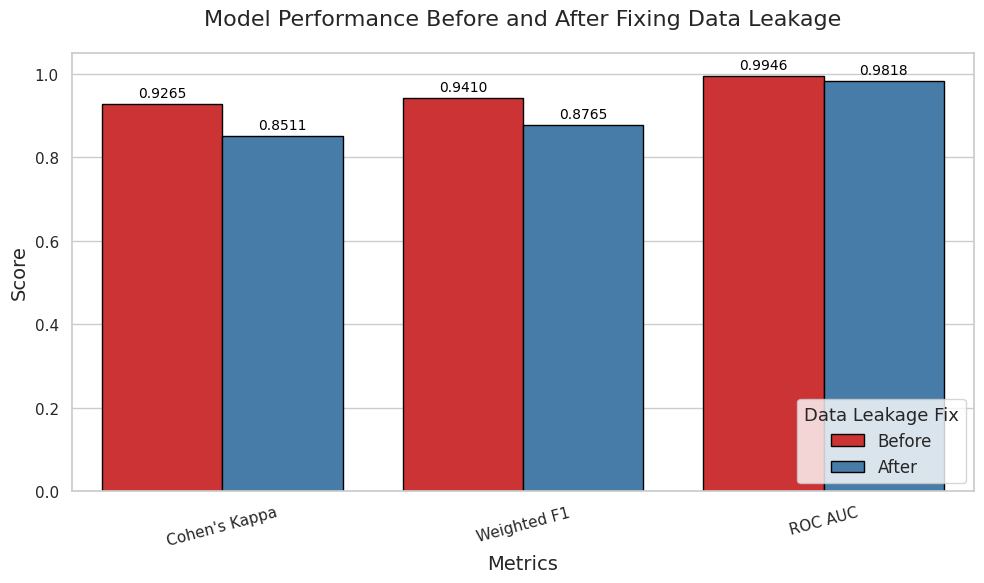

In [7]:
# Import necessary libraries 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Define your updated data
data = {
    'Tuning': ['Before', 'After', 'Before', 'After', 'Before', 'After'],
    'Metric': ["Cohen's Kappa", "Cohen's Kappa", 'Weighted F1', 'Weighted F1', 'ROC AUC', 'ROC AUC'],
    'Score': [0.9265, 0.8511, 0.9410, 0.8765, 0.9946, 0.9818]
}

# Create the DataFrame
df = pd.DataFrame(data)

# Display the DataFrame for verification
print("DataFrame:")
print(df)

# Verify that all 'Score' values are numeric and greater than zero
if df['Score'].isnull().any():
    raise ValueError("There are NaN values in the 'Score' column. Please check your data.")
if (df['Score'] <= 0).any():
    print("Warning: There are non-positive values in the 'Score' column.")

# Initialize the matplotlib figure with increased height to accommodate annotations
plt.figure(figsize=(10, 6))

# Retrieve the 'Set2' palette and reverse it
reversed_palette = sns.color_palette('Set1')# [::-1]

# Create a grouped barplot directly using the DataFrame with the reversed palette
ax = sns.barplot(
    x='Metric',
    y='Score',
    hue='Tuning',
    data=df,
    palette=reversed_palette,  # Reversed palette
    edgecolor='black'
)

# Add titles and labels with optional padding
plt.title('Model Performance Before and After Fixing Data Leakage', fontsize=16, pad=20)
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Score', fontsize=14)

# Set y-axis limits slightly above 1 to prevent annotations from overlapping the title
plt.ylim(0, 1.05)  # Adjust as needed

# Rotate x-axis labels if necessary
plt.xticks(rotation=15)

# Add value labels on top of each bar with reduced offset and smaller font size
for p in ax.patches:
    height = p.get_height()
    # Only annotate bars with height greater than zero
    if height > 0:
        ax.annotate(f'{height:.4f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 3),
                    textcoords='offset points')

# Improve legend: move it to the bottom right
plt.legend(title='Data Leakage Fix', fontsize=12, title_fontsize=13,
           loc='lower right', bbox_to_anchor=(1, 0))

# Adjust layout to make room for the legend and prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

# Optionally, save the plot as a PNG file
# plt.savefig('model_performance_comparison_reversed_palette.png', dpi=300)


DataFrame:
  Model       Metric   Score
0   KNN  Weighted F1  0.7766
1   SVC  Weighted F1  0.8853
2   GCN  Weighted F1  0.9073
3   CNN  Weighted F1  0.8149
/tmp/ipykernel_73/2532030384.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_73/2532030384.py:36: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  ax = sns.barplot(


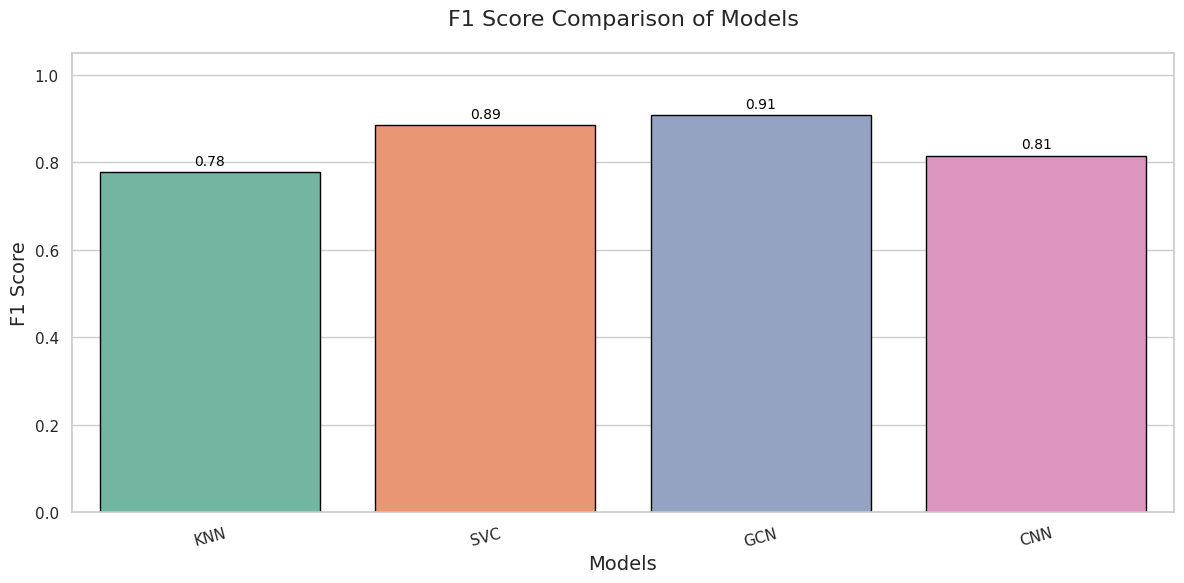

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Define your updated data with placeholders for the scores of four models
data = {
    'Model': ['KNN', 'SVC', 'GCN', 'CNN'],
    'Metric': ['Weighted F1', 'Weighted F1', 'Weighted F1', 'Weighted F1'],
    'Score': [0.7766, 0.8853, 0.9073, 0.8149]  
}

# Create the DataFrame
df = pd.DataFrame(data)

# Display the DataFrame for verification
print("DataFrame:")
print(df)

# Verify that all 'Score' values are numeric and greater than zero
if df['Score'].isnull().any():
    raise ValueError("There are NaN values in the 'Score' column. Please check your data.")
if (df['Score'] <= 0).any():
    print("Warning: There are non-positive values in the 'Score' column.")

# Initialize the matplotlib figure with increased height to accommodate annotations
plt.figure(figsize=(12, 6))

# Retrieve the 'Set2' palette
palette = sns.color_palette('Set2')

# Create a barplot directly using the DataFrame
ax = sns.barplot(
    x='Model',
    y='Score',
    data=df,
    palette=palette,  # Set palette
    edgecolor='black'
)

# Add titles and labels with optional padding
plt.title('F1 Score Comparison of Models', fontsize=16, pad=20)
plt.xlabel('Models', fontsize=14)
plt.ylabel('F1 Score', fontsize=14)

# Set y-axis limits slightly above 1 to prevent annotations from overlapping the title
plt.ylim(0, 1.05)  # Adjust as needed

# Rotate x-axis labels if necessary
plt.xticks(rotation=15)

# Add value labels on top of each bar with reduced offset and smaller font size
for p in ax.patches:
    height = p.get_height()
    # Only annotate bars with height greater than zero
    if height > 0:
        ax.annotate(f'{height:.2f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 3),
                    textcoords='offset points')

# Adjust layout to make room for the legend and prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

# Optionally, save the plot as a PNG file
# plt.savefig('f1_score_comparison_models.png', dpi=300)


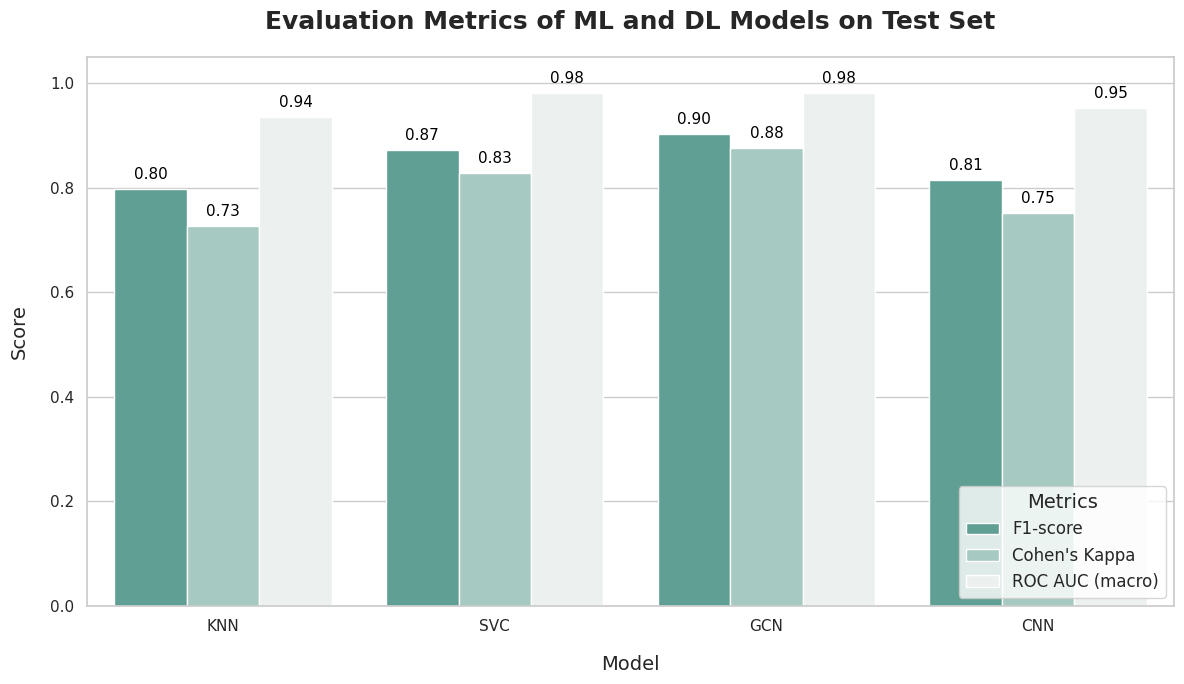

In [30]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# If you're using Jupyter Notebook or JupyterLab, uncomment the following line:
# %matplotlib inline

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Define the data
data = {
    'Model': ['KNN', 'SVC', 'GCN', 'CNN'],
    'F1-score': [0.7964, 0.8727, 0.9026, 0.8144],
    'Cohen\'s Kappa': [0.7258, 0.8276, 0.8756, 0.7517],
    'ROC AUC (macro)': [0.9354, 0.9806, 0.9805, 0.9524]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Melt the DataFrame to long-form for seaborn
df_melted = pd.melt(df, id_vars='Model', var_name='Metric', value_name='Score')

# Define a color palette (Set2 has soft, distinguishable colors)
palette = sns.color_palette("light:#5A9_r", n_colors=3)

# Initialize the matplotlib figure
plt.figure(figsize=(12, 7))

# Create a barplot
bar_plot = sns.barplot(x='Model', y='Score', hue='Metric', data=df_melted, palette=palette)

# Add title and labels with increased font sizes
plt.title('Evaluation Metrics of ML and DL Models on Test Set', fontsize=18, weight='bold', pad=20)
plt.xlabel('Model', fontsize=14, labelpad=15)
plt.ylabel('Score', fontsize=14, labelpad=15)

# Customize the legend
plt.legend(title='Metrics', fontsize=12, title_fontsize=14, loc='lower right', bbox_to_anchor=(1, 0))

# Add data labels on top of each bar
for patch in bar_plot.patches:
    # Get the height of each bar
    height = patch.get_height()
    # Only annotate bars with height greater than 0 to avoid labeling invisible bars
    if height > 0:
        bar_plot.annotate(f'{height:.2f}',
                          (patch.get_x() + patch.get_width() / 2., height),
                          ha='center', va='bottom',
                          fontsize=11,
                          color='black',
                          xytext=(0, 5),  # Offset label by 5 points above the bar
                          textcoords='offset points')

# Adjust y-axis to accommodate data labels
plt.ylim(0, 1.05)

# Improve layout spacing
plt.tight_layout()

# Display the plot
plt.show()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=db2be735-7b76-4a43-b76e-661e91470b42' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>